**Описание проекта**

Для оптимизации производственных расходов, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. 

Задача — построить модель, которая будет предсказывать температуру сплава. 

Заказчик хочет использовать разработанную модель для имитации технологического процесса.


**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Описание данных**

data_arc_new.csv — данные об электродах
   - key — номер партии;
   - Начало нагрева дугой — время начала нагрева;
   - Конец нагрева дугой — время окончания нагрева;
   - Активная мощность — значение активной мощности;
   - Реактивная мощность — значение реактивной мощности.
   
data_bulk_new.csv — данные о подаче сыпучих материалов (объём)
 - key — номер партии;
 - Bulk 1 … Bulk 15 — объём подаваемого материала.
 
data_bulk_time_new.csv — данные о подаче сыпучих материалов (время)
- key — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала.

data_gas_new.csv — данные о продувке сплава газом
- key — номер партии;
- Газ 1 — объём подаваемого газа.

data_temp_new.csv — результаты измерения температуры
- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.

data_wire_new.csv — данные о проволочных материалах (объём)
- key — номер партии;
- Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

data_wire_time_new.csv — данные о проволочных материалах (время)
- key — номер партии;
- Wire 1 … Wire 9 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии.

**Алгоритм решения** 

1. Загрузка и первичный осмотр данных;
2. Исследовательский анализ и предобработка данных;
3. Объединение выбранных признаков в один датафрейм по ключу;
4. Исследовательский анализ и предобработка данных объединённого датафрейма;
5. Подготовка данных для обучения модели;
6. Обучение моделей машинного обучения;
7. Выбор лучшей модели;
8. Исследование важности признаков;
9. Общий вывод и рекомендации заказчику.

In [1]:
%%html
<style>
  div.output_scroll {
    height: auto !important;
  }
</style>

In [2]:
!pip install phik -q
!pip install shap -q

import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import shap

from functools import reduce
from phik import phik_matrix
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    HalvingRandomSearchCV,
    cross_val_score
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer
)

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

test_size = 0.25
RANDOM_STATE = 30625

## Шаг 1. Загрузка данных|

In [3]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv')
data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')

In [4]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Изменим тим данных с object на datetime64. 

In [6]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [7]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Минимальная реактивная мощность отрицательна. Это возможно, но означает, что система отдает мощность, а не потребляет ее для нагрева. 

In [8]:
data_arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [9]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [10]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [11]:
data_bulk_new.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [12]:
data_bulk_new.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Пропуски указывают на то, что данный материал не использовался в процессе.

In [13]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [14]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [15]:
bulk_columns = [f'Bulk {i}' for i in range(1, 16)]

for col in bulk_columns:
    data_bulk_time_new[col] = pd.to_datetime(data_bulk_time_new[col]) 

In [16]:
data_bulk_time_new.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [17]:
data_bulk_time_new.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [18]:
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [19]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [20]:
data_gas_new.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [21]:
data_gas_new.isna().sum()

key      0
Газ 1    0
dtype: int64

In [22]:
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [23]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [24]:
data_temp_new['Время замера'] = pd.to_datetime(data_temp_new['Время замера'])

In [25]:
data_temp_new.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [26]:
data_temp_new.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

In [27]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [29]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [30]:
data_wire_new.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [31]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [33]:
wire_columns = [f'Wire {i}' for i in range(1, 10)]

for col in wire_columns:
    data_wire_time_new[col] = pd.to_datetime(data_wire_time_new[col]) 

In [34]:
data_wire_time_new.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [35]:
data_wire_time_new.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

В данных присутствуют пропуски, которые указывают на то, что данный материал не использовался в процессе. Также были скорректированы типы данных. 

## Шаг 2. Исследовательский анализ и предобработка данных

In [36]:
def num_variable_analysis(data, column, title):
    print(data[column].describe())
    fig, ax = plt.subplots(figsize = (17,2))
    ax = data[[column]].boxplot(vert = False, ax =ax)
    ax.set_title(f'Диаграмма размаха {title}')
    plt.show()

In [37]:
def num_variable_visualization(data, column, title):
    data = data[column].plot(title=title, kind='hist', bins=25, grid=True, 
                                             figsize=(10,6), color='skyblue', edgecolor='black')
    data.set_xlabel(column)
    data.set_ylabel(title)
    plt.show()

### Исследуем датафрейм с данными об электродах

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64


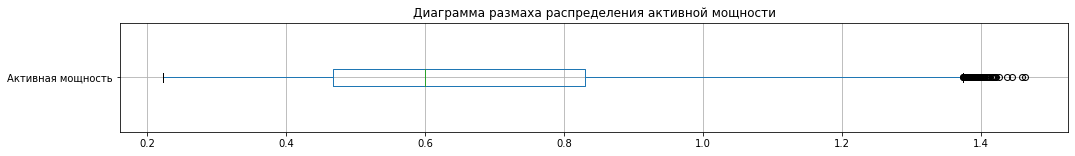

In [38]:
num_variable_analysis(data_arc, 'Активная мощность', 'распределения активной мощности')

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64


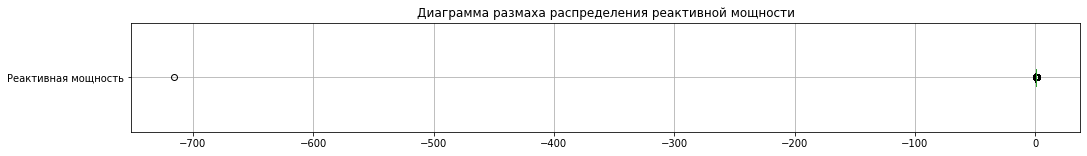

In [39]:
num_variable_analysis(data_arc, 'Реактивная мощность', 'распределения реактивной мощности')

Обнаружен супер выброс, следует его удалить. Остальные выбросы возможны, лучше их оставить.

In [40]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [41]:
data_arc = data_arc[data_arc['key'] != 2116]

count    14872.000000
mean         0.487112
std          0.197623
min          0.153777
25%          0.337175
50%          0.441667
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64


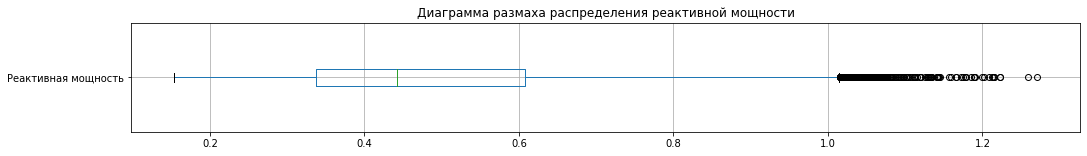

In [42]:
num_variable_analysis(data_arc, 'Реактивная мощность', 'распределения реактивной мощности')

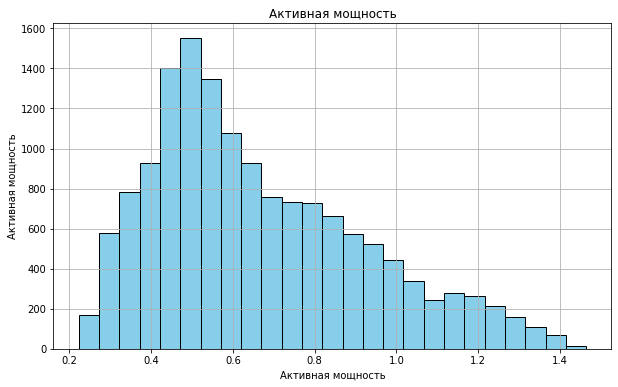

In [43]:
num_variable_visualization(data_arc, 'Активная мощность', 'Активная мощность')

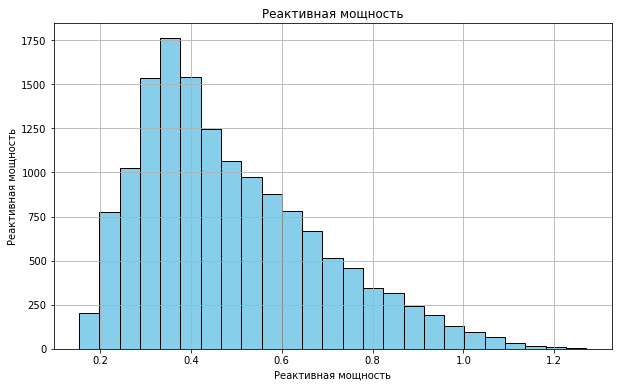

In [44]:
num_variable_visualization(data_arc, 'Реактивная мощность', 'Реактивная мощность')

Основная масса значений сосредоточена в нижнем диапазоне (около 0.3–0.6 у активной мощности, 0.3–0.5 у реактивной), обе гистограммы имеют смещение вправо. В большинстве нагревов значения мощности невысоки, но время от времени встречаются отдельные случаи с большими мощностями.



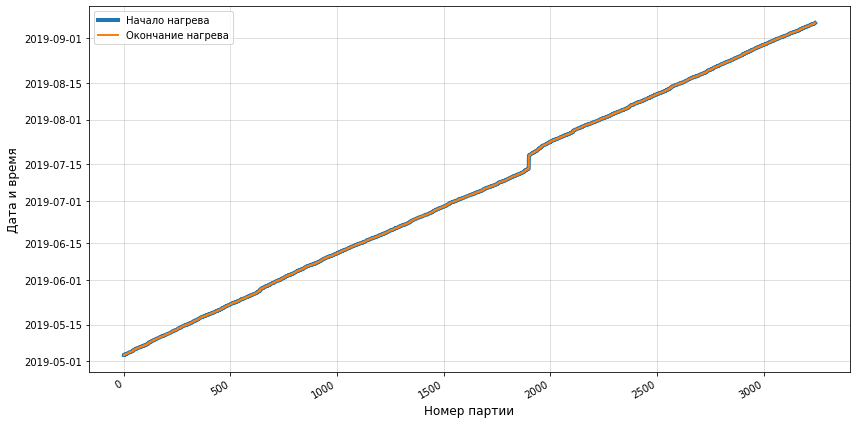

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(data_arc['key'], data_arc['Начало нагрева дугой'], label='Начало нагрева', linewidth=4)
ax.plot(data_arc['key'], data_arc['Конец нагрева дугой'],   label='Окончание нагрева', linewidth=2)

ax.set_xlabel('Номер партии', fontsize=12)
ax.set_ylabel('Дата и время', fontsize=12)

ax.grid(True, alpha=0.5)
ax.legend()
fig.autofmt_xdate()   

plt.tight_layout()
plt.show()

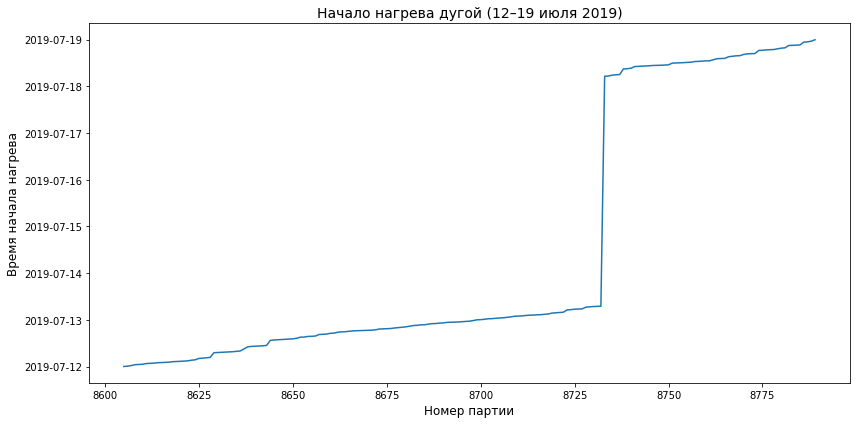

In [46]:
mask = (
    (data_arc['Начало нагрева дугой'] > '2019-07-12') &
    (data_arc['Начало нагрева дугой'] < '2019-07-19')
)


data_arc.loc[mask, 'Начало нагрева дугой'] \
    .plot(figsize=(12, 6))   

plt.title('Начало нагрева дугой (12–19 июля 2019)', fontsize=14)
plt.xlabel('Номер партии', fontsize=12)
plt.ylabel('Время начала нагрева', fontsize=12)
plt.tight_layout()
plt.show()

Аномальных значений по времени обнаружено не было, в июле была работа была остановлена на несколько дней.

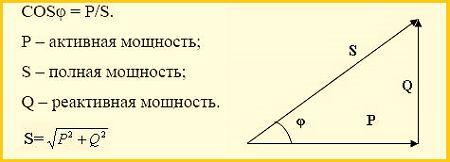

In [47]:
data_arc['Полная мощность'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)**(0.5)

Также стоит добавить столбец, который содержит общее время нагрева и столбец с коэффициентом мощности.

In [48]:
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds()

In [49]:
data_arc['Коэффициент мощности'] = data_arc['Активная мощность'] / data_arc['Полная мощность']   

count    14872.000000
mean         0.823385
std          0.323494
min          0.275718
25%          0.578813
50%          0.746591
75%          1.030390
max          1.898158
Name: Полная мощность, dtype: float64


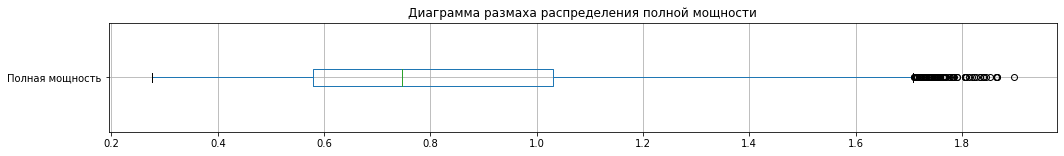

In [50]:
num_variable_analysis(data_arc, 'Полная мощность', 'распределения полной мощности')

count    14872.000000
mean       171.688004
std         98.193604
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: Время нагрева, dtype: float64


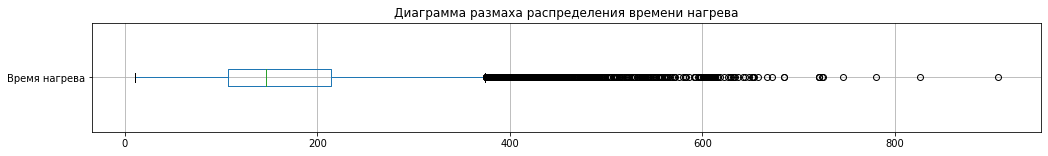

In [51]:
num_variable_analysis(data_arc, 'Время нагрева', 'распределения времени нагрева')

count    14872.000000
mean         0.805890
std          0.027655
min          0.707722
25%          0.788058
50%          0.809705
75%          0.827039
max          0.880503
Name: Коэффициент мощности, dtype: float64


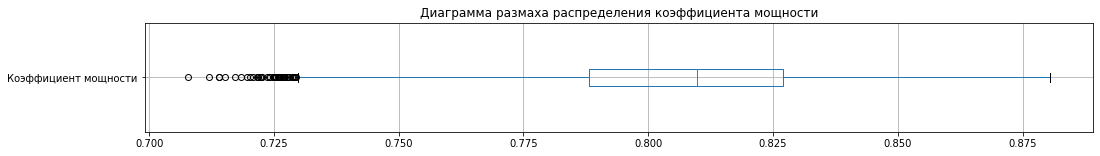

In [52]:
num_variable_analysis(data_arc, 'Коэффициент мощности', 'распределения коэффициента мощности')

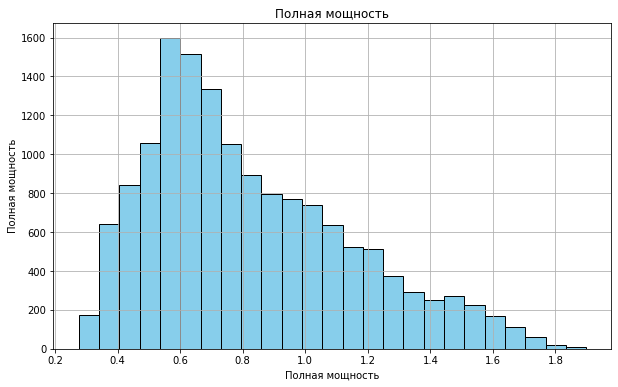

In [53]:
num_variable_visualization(data_arc, 'Полная мощность', 'Полная мощность')

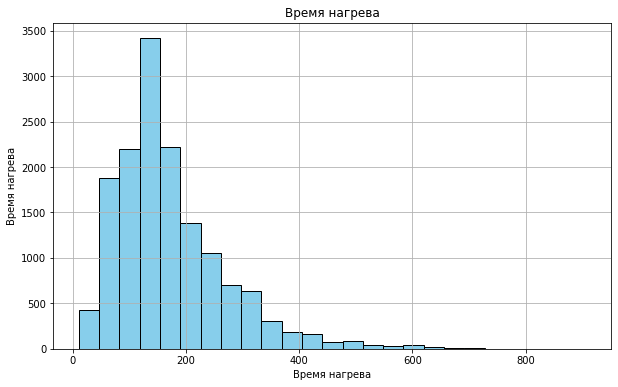

In [54]:
num_variable_visualization(data_arc, 'Время нагрева', 'Время нагрева')

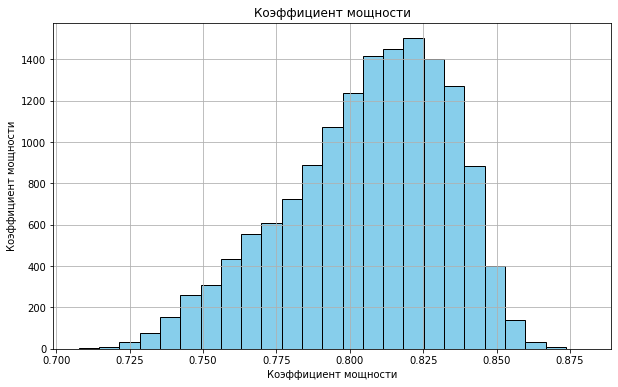

In [55]:
num_variable_visualization(data_arc, 'Коэффициент мощности', 'Коэффициент мощности')

В добавленных признаках есть выбросы, но они возможны. Гистограммы немного смещены.

In [56]:
data_arc.drop(columns=['Начало нагрева дугой', 'Конец нагрева дугой'], inplace=True)

### Исследуем датафрейм с данными  о подаче сыпучих материалов

count    252.000000
mean      39.242063
std       18.277654
min       10.000000
25%       27.000000
50%       31.000000
75%       46.000000
max      185.000000
Name: Bulk 1, dtype: float64


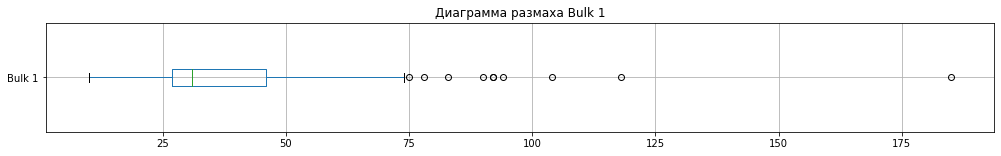

count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: Bulk 2, dtype: float64


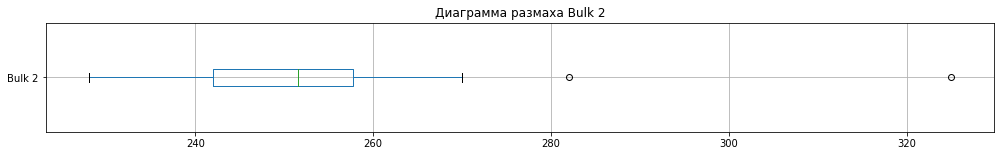

count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64


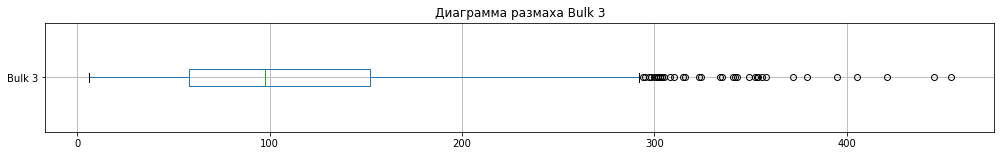

count    1014.000000
mean      104.394477
std        48.184126
min        12.000000
25%        72.000000
50%       102.000000
75%       133.000000
max       281.000000
Name: Bulk 4, dtype: float64


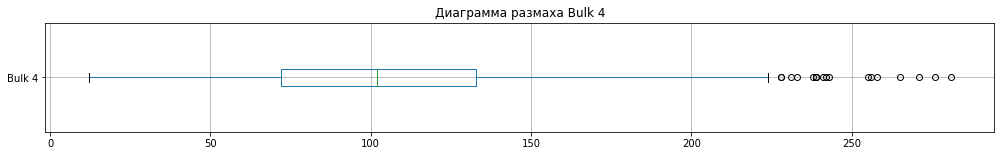

count     77.000000
mean     107.025974
std       81.790646
min       11.000000
25%       70.000000
50%       86.000000
75%      132.000000
max      603.000000
Name: Bulk 5, dtype: float64


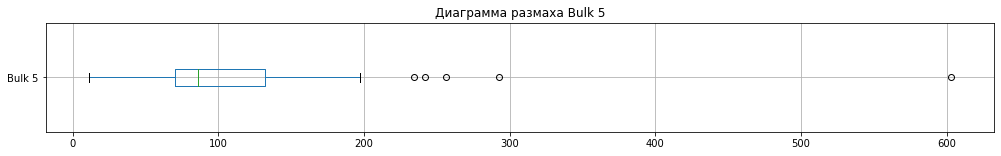

count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: Bulk 6, dtype: float64


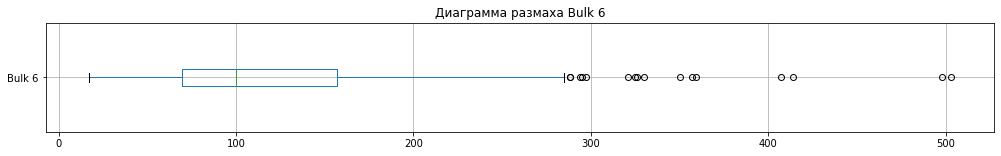

count     25.000000
mean     305.600000
std      191.022904
min       47.000000
25%      155.000000
50%      298.000000
75%      406.000000
max      772.000000
Name: Bulk 7, dtype: float64


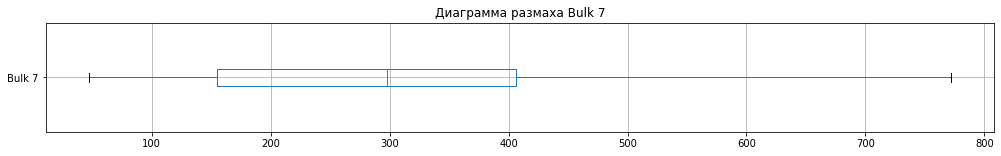

count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: Bulk 8, dtype: float64


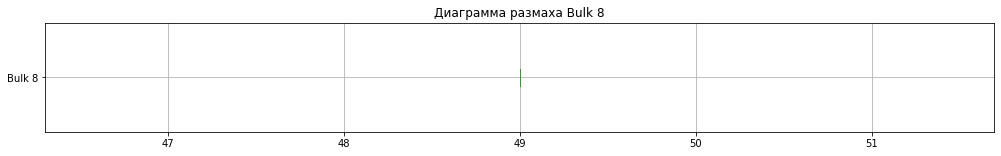

count     19.000000
mean      76.315789
std       21.720581
min       63.000000
25%       66.000000
50%       68.000000
75%       70.500000
max      147.000000
Name: Bulk 9, dtype: float64


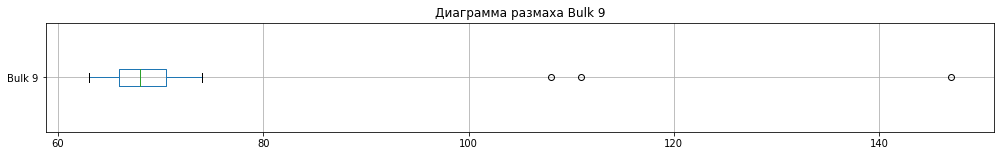

count    176.000000
mean      83.284091
std       26.060347
min       24.000000
25%       64.000000
50%       86.500000
75%      102.000000
max      159.000000
Name: Bulk 10, dtype: float64


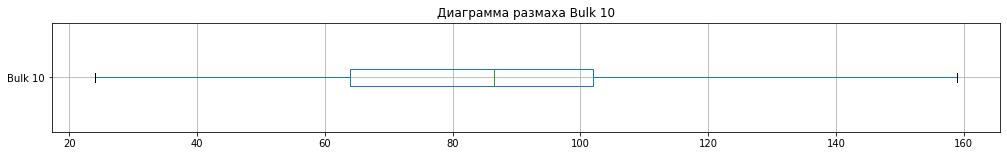

count    177.000000
mean      76.819209
std       59.655365
min        8.000000
25%       25.000000
50%       64.000000
75%      106.000000
max      313.000000
Name: Bulk 11, dtype: float64


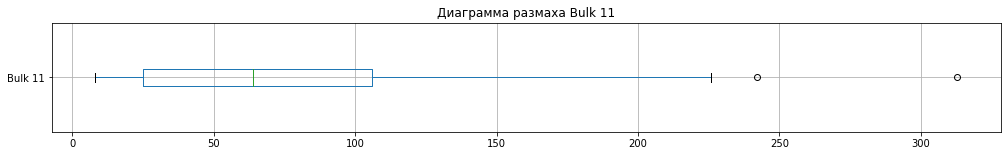

count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: Bulk 12, dtype: float64


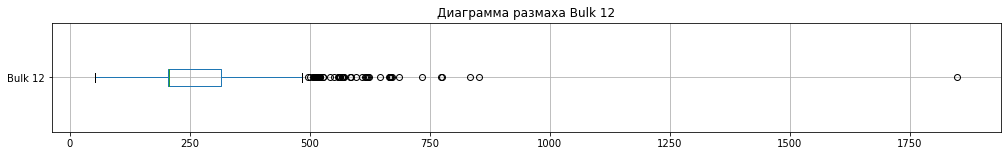

count     18.000000
mean     181.111111
std       46.088009
min      151.000000
25%      153.250000
50%      155.500000
75%      203.500000
max      305.000000
Name: Bulk 13, dtype: float64


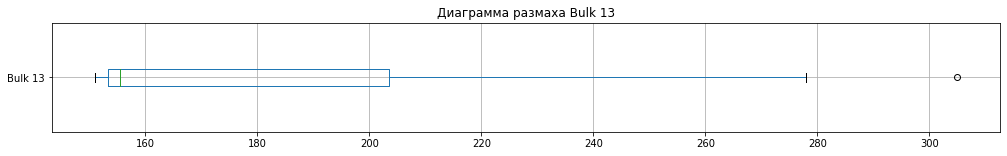

count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: Bulk 14, dtype: float64


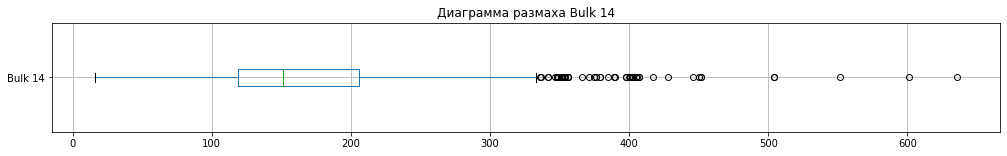

count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: Bulk 15, dtype: float64


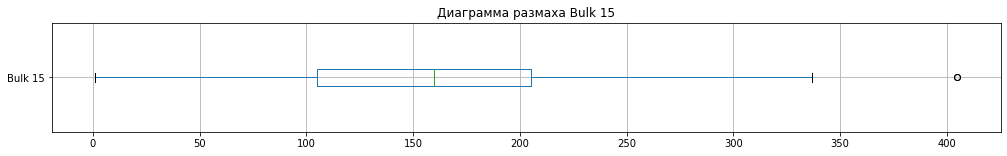

In [57]:
bulk_cols = [col for col in data_bulk_new.columns if col.startswith('Bulk')]

for col in bulk_cols:
    num_variable_analysis(data_bulk_new, col, title=col)

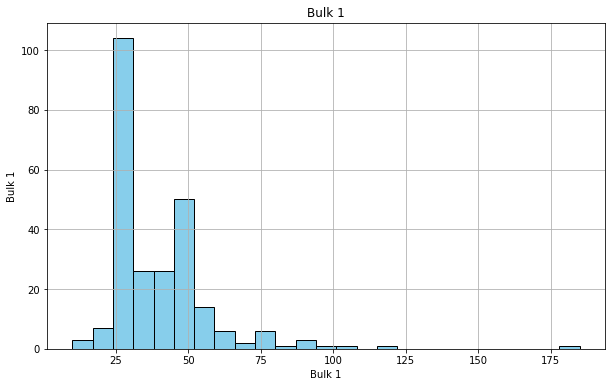

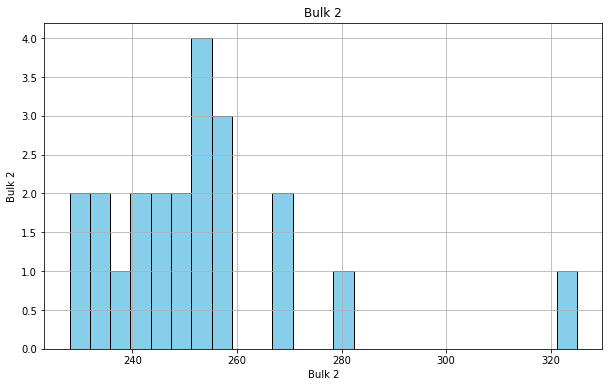

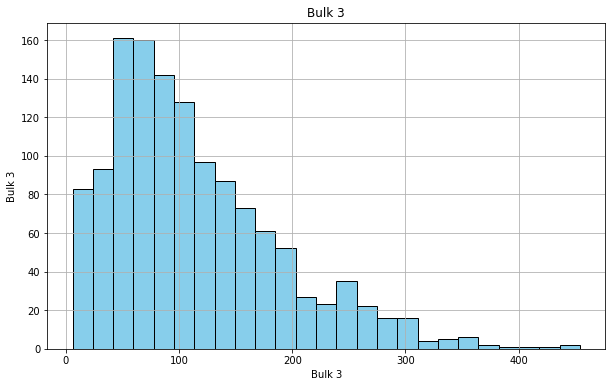

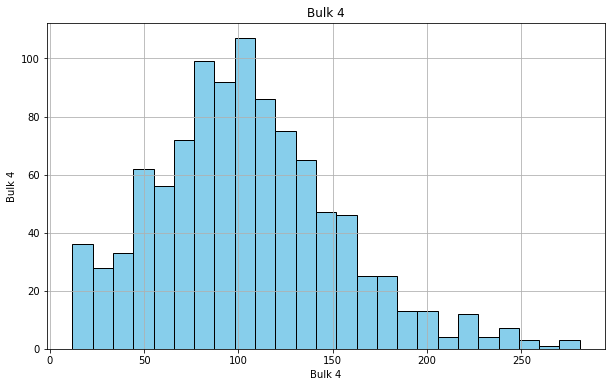

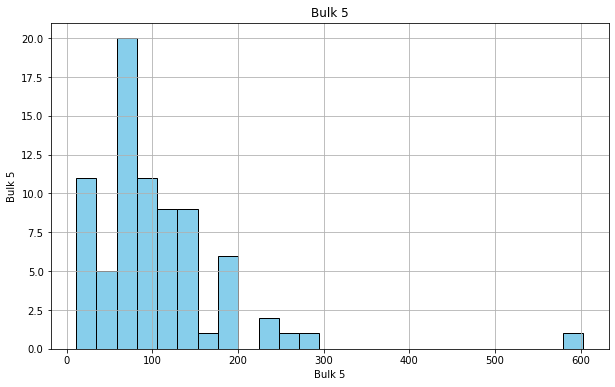

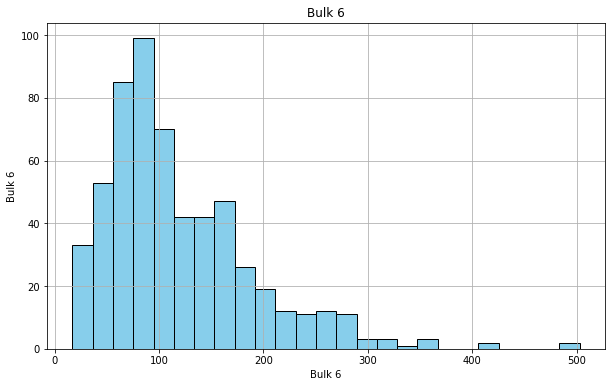

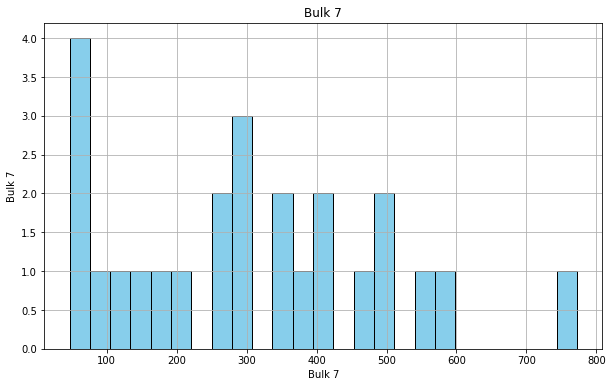

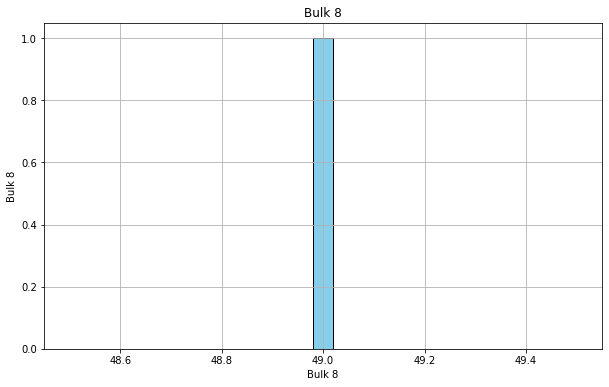

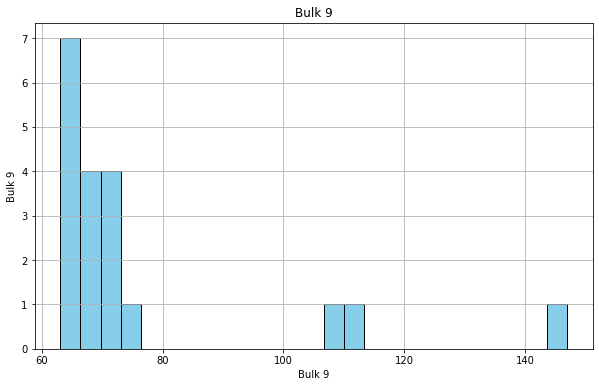

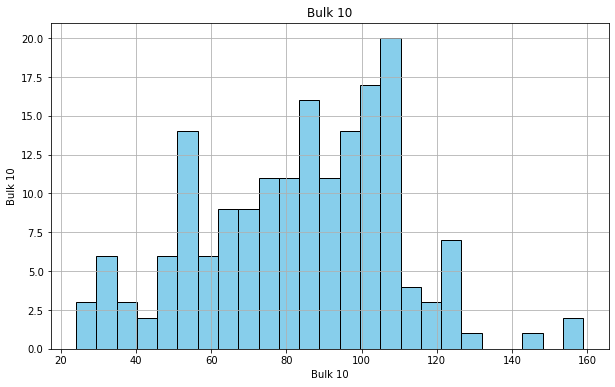

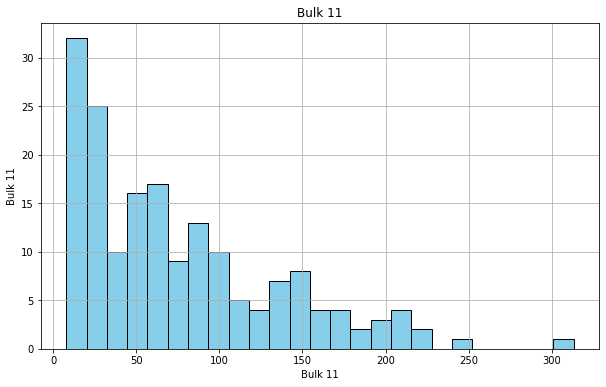

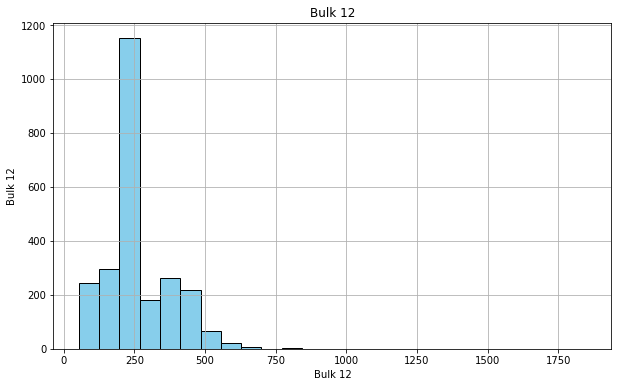

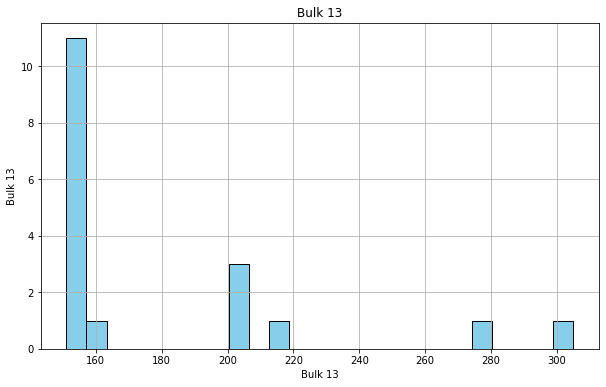

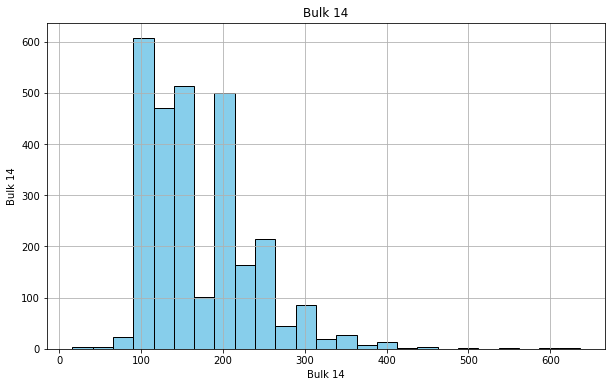

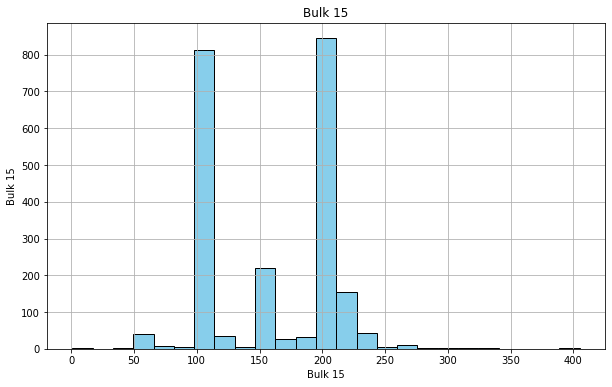

In [58]:
for col in bulk_cols:
    num_variable_visualization(data_bulk_new, col, title=col)

Присутствую выбросы. Пропуски заменим на 0.

In [59]:
data_bulk_new = data_bulk_new.fillna(0)

Добавим новый признак, который содержит суммарный объем материала.

In [60]:
data_bulk_new['Суммарный объем'] = data_bulk_new[bulk_cols].sum(axis=1)

count    3129.000000
mean      595.503356
std       276.557794
min        19.000000
25%       429.000000
50%       591.000000
75%       772.000000
max      3235.000000
Name: Суммарный объем, dtype: float64


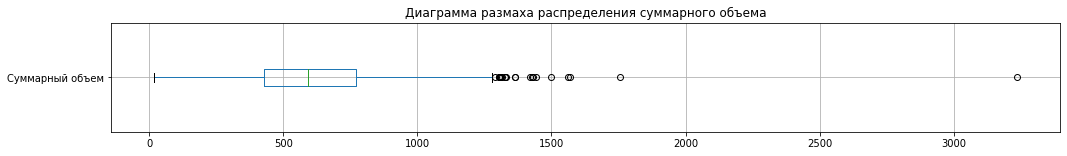

In [61]:
num_variable_analysis(data_bulk_new, 'Суммарный объем', 'распределения суммарного объема')

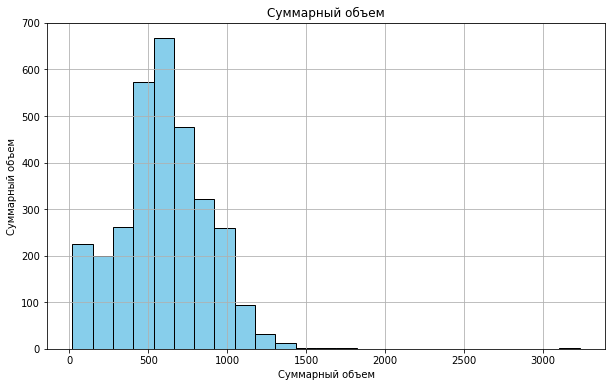

In [62]:
num_variable_visualization(data_bulk_new, 'Суммарный объем', 'Суммарный объем')

In [63]:
data_bulk_new[data_bulk_new['Суммарный объем'] > 3000]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Суммарный объем
303,322,185.0,0.0,101.0,58.0,0.0,0.0,406.0,0.0,0.0,0.0,0.0,1849.0,0.0,636.0,0.0,3235.0


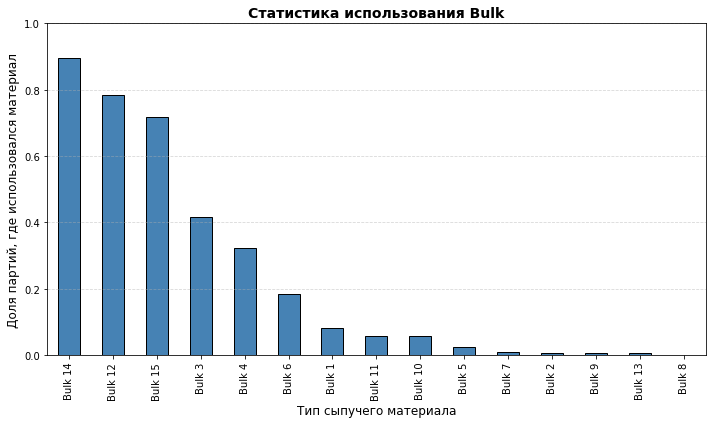

In [64]:
usage_rate = (data_bulk_new[bulk_cols] > 0).mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = usage_rate.plot(
    kind='bar',
    color='steelblue',
    edgecolor='black'
)

ax.set_title('Статистика использования Bulk', fontsize=14, fontweight='bold')
ax.set_ylabel('Доля партий, где использовался материал', fontsize=12)
ax.set_xlabel('Тип сыпучего материала', fontsize=12)
ax.set_ylim(0, 1)        
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Стоит удалить Bulk 1, Bulk 11, Bulk 10, Bulk 5, Bulk 7, Bulk 2, Bulk 9, Bulk 13,  Bulk 8, так как они очень редко используются. 

In [65]:
del_col=['Bulk 1', 'Bulk 11', 'Bulk 10', 'Bulk 5', 'Bulk 7', 'Bulk 2', 'Bulk 9', 'Bulk 13', 'Bulk 8']
data_bulk_new.drop(columns=del_col, inplace=True)
data_bulk_time_new.drop(columns=del_col, inplace=True)

### Исследуем датафрейм с данными о продувке сплава газом

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64


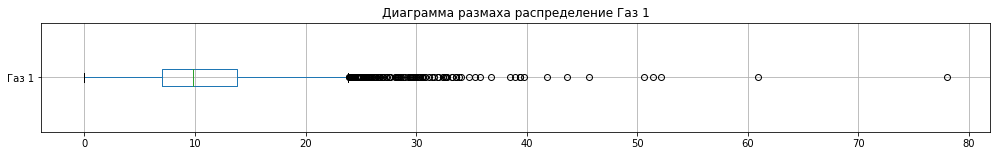

In [66]:
num_variable_analysis(data_gas_new,'Газ 1', 'распределение Газ 1')

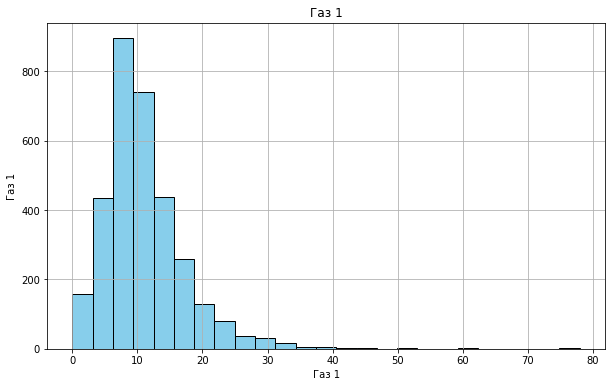

In [67]:
num_variable_visualization(data_gas_new,'Газ 1', 'Газ 1')

Есть аномальные значения, гистограмма смещена.

### Исследуем датафрейм с результатами измерения температуры

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64


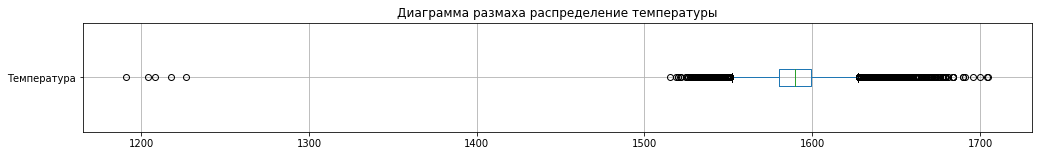

In [68]:
num_variable_analysis(data_temp_new,'Температура', 'распределение температуры')

Можно увидеть супер выбросы, когда температура меньше 1400. 

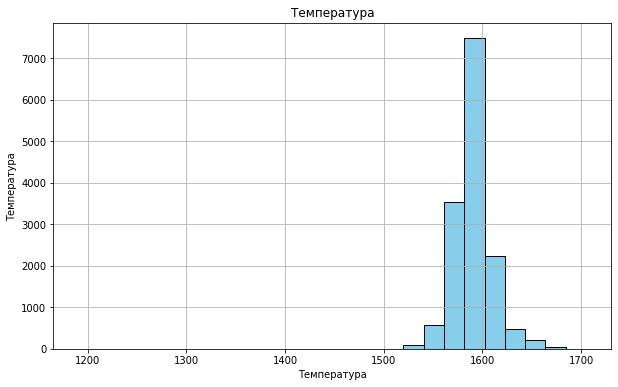

In [69]:
num_variable_visualization(data_temp_new,'Температура', 'Температура')

In [70]:
data_temp_new[data_temp_new['Температура'] < 1400]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [71]:
anomalous_keys = data_temp_new.loc[data_temp_new['Температура'] < 1400, 'key'].unique()


data_temp_new = data_temp_new.loc[~data_temp_new['key'].isin(anomalous_keys)].copy()

Удалили партии с супер выбросами, значение температур в основном сосредоточено от 1580 до 1650. Добавим столбцы с начальной и конечной температурами.

In [72]:
df_temp = data_temp_new.copy()
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'], dayfirst=True)

last_times = df_temp.groupby('key')['Время замера'].max().rename('last_time')

df_temp = df_temp.merge(last_times, on='key')

valid_last = df_temp[
    (df_temp['Время замера'] == df_temp['last_time']) &
    df_temp['Температура'].notna()
]['key'].unique()

df_temp = df_temp[df_temp['key'].isin(valid_last)]

df_temp = df_temp.dropna(subset=['Температура'])

data_temp = (
    df_temp.sort_values(['key','Время замера'])
           .groupby('key', as_index=False)
           .agg(
              temp_start=('Температура','first'),
              temp_end  =('Температура','last')
           )
)

data_temp = data_temp.rename(columns={
    'temp_start':'Начальная температура',
    'temp_end':'Конечная температура'
})


print("3000 остался?", 3000 in data_temp['key'].values)

3000 остался? False


count    2473.000000
mean     1589.016175
std        24.996127
min      1519.000000
25%      1572.000000
50%      1588.000000
75%      1605.000000
max      1679.000000
Name: Начальная температура, dtype: float64


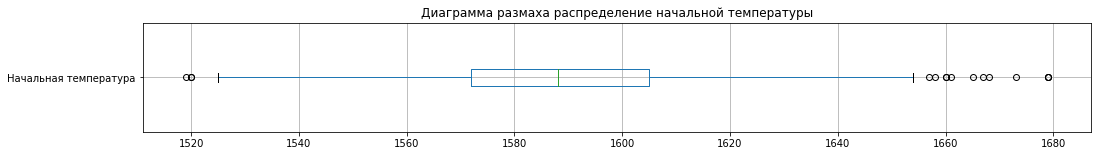

In [74]:
num_variable_analysis(data_temp,'Начальная температура', 'распределение начальной температуры')

count    2473.000000
mean     1595.338051
std        16.031388
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: Конечная температура, dtype: float64


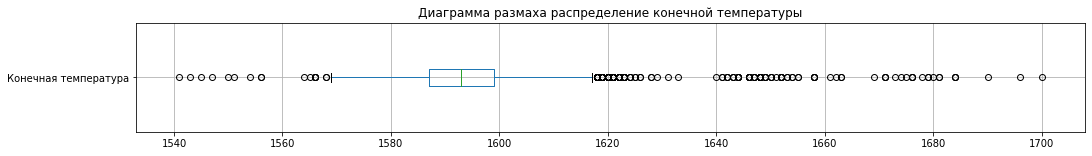

In [75]:
num_variable_analysis(data_temp,'Конечная температура', 'распределение конечной температуры')

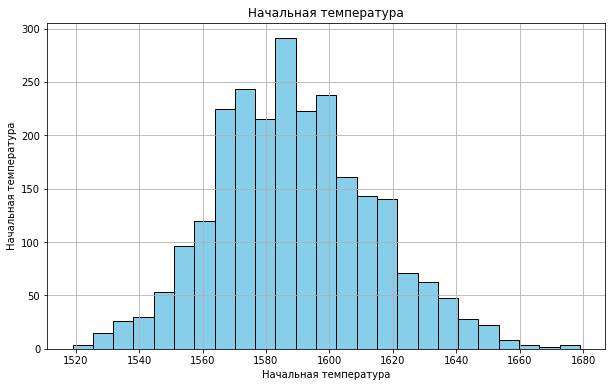

In [76]:
num_variable_visualization(data_temp,'Начальная температура', 'Начальная температура')

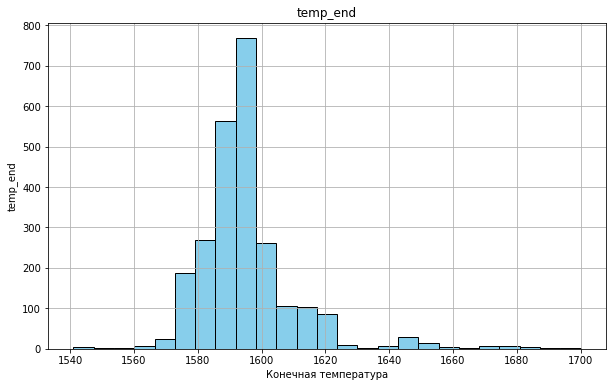

In [77]:
num_variable_visualization(data_temp,'Конечная температура', 'temp_end')

Для начальной температуры распределение практически симметричное, близкое к нормальному. Есть единичные выбросы ниже 1520 °C и выше 1650 °C, но они крайне редки.

Для конечной температуры распределение тоже примерно нормальное, но чуть более «узкое» вокруг центра — большая часть значений лежит в интервале 1580 – 1620 °C. Выбросы в обе стороны есть, но их доля невелика.

In [78]:
data_temp

,key,Начальная температура,Конечная температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2468,2495,1570.0,1591.0
2469,2496,1554.0,1591.0
2470,2497,1571.0,1589.0
2471,2498,1591.0,1594.0


### Исследуем датафрейм с данными о проволочных материалах

count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060483
max       330.314424
Name: Wire 1, dtype: float64


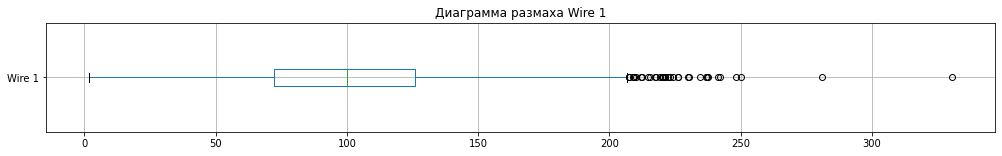

count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64


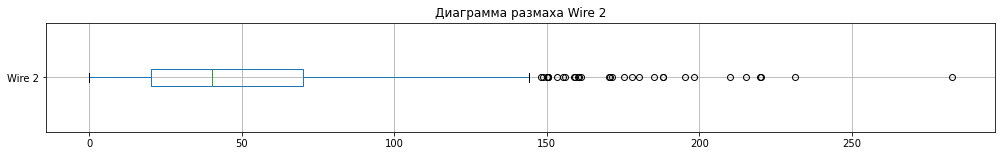

count     63.000000
mean     189.482681
std       99.513444
min        0.144144
25%       95.135044
50%      235.194977
75%      276.252014
max      385.008668
Name: Wire 3, dtype: float64


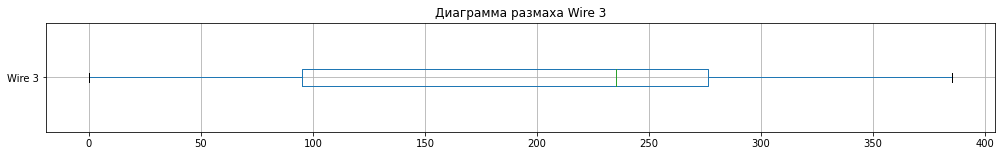

count     14.000000
mean      57.442841
std       28.824667
min       24.148801
25%       40.807002
50%       45.234282
75%       76.124619
max      113.231044
Name: Wire 4, dtype: float64


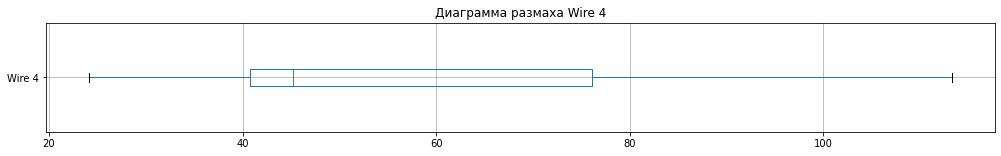

count     1.000
mean     15.132
std         NaN
min      15.132
25%      15.132
50%      15.132
75%      15.132
max      15.132
Name: Wire 5, dtype: float64


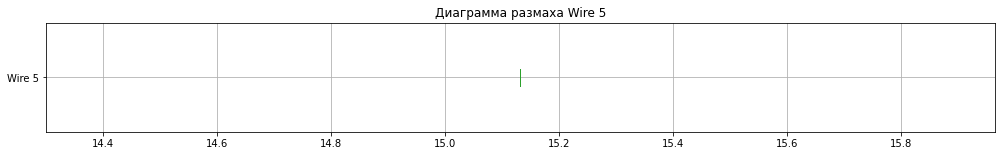

count     73.000000
mean      48.016974
std       33.919845
min        0.034320
25%       25.053600
50%       42.076324
75%       64.212723
max      180.454575
Name: Wire 6, dtype: float64


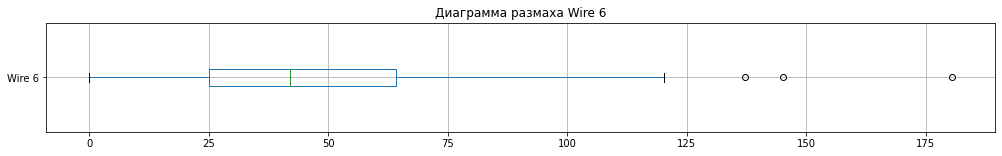

count    11.000000
mean     10.039007
std       8.610584
min       0.234208
25%       6.762756
50%       9.017009
75%      11.886057
max      32.847674
Name: Wire 7, dtype: float64


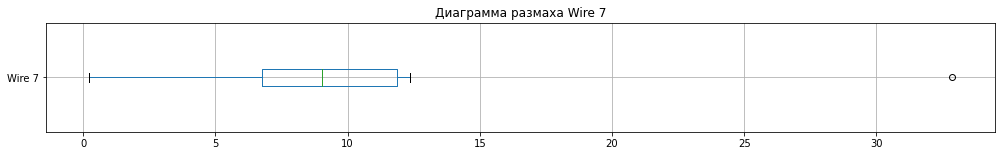

count     19.000000
mean      53.625193
std       16.881728
min       45.076721
25%       46.094879
50%       46.279999
75%       48.089603
max      102.762401
Name: Wire 8, dtype: float64


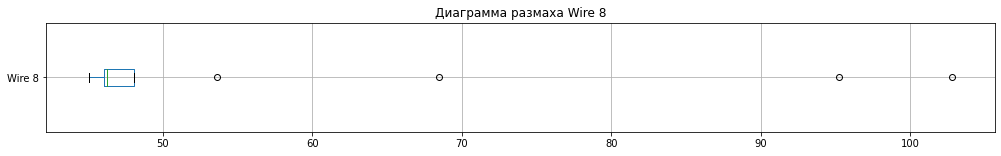

count    29.000000
mean     34.155752
std      19.931616
min       4.622800
25%      22.058401
50%      30.066399
75%      43.862003
max      90.053604
Name: Wire 9, dtype: float64


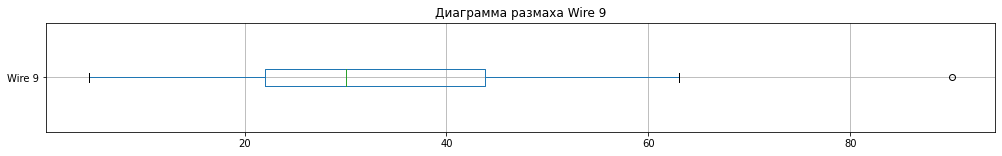

In [79]:
wire_cols = [col for col in data_wire_new.columns if col.startswith('Wire')]

for col in wire_cols:
    num_variable_analysis(data_wire_new, col, title=col)

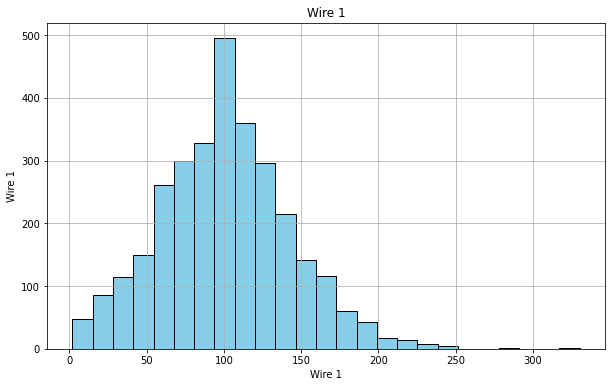

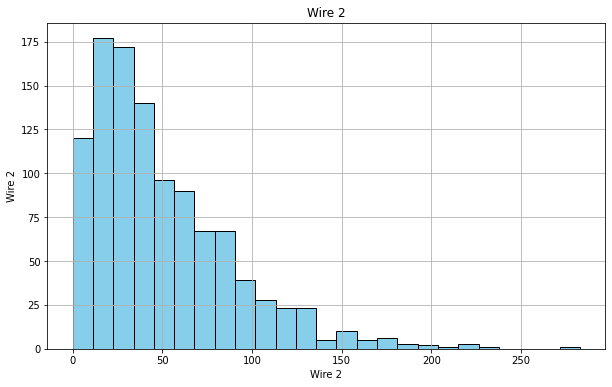

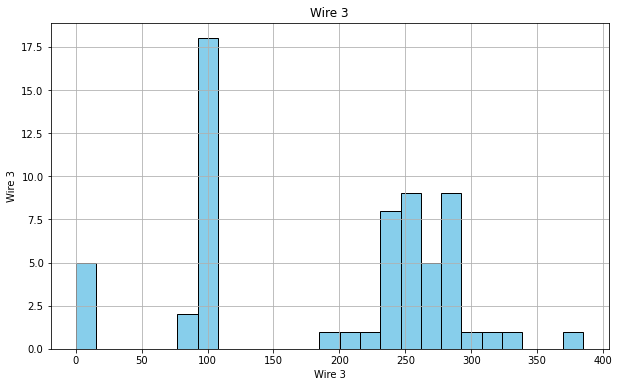

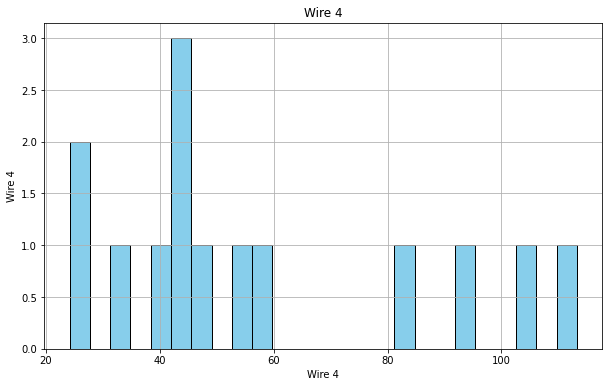

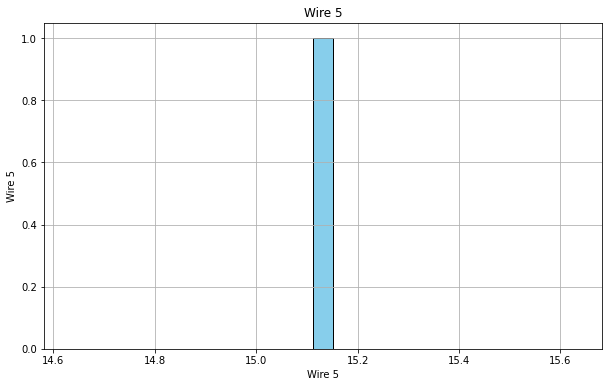

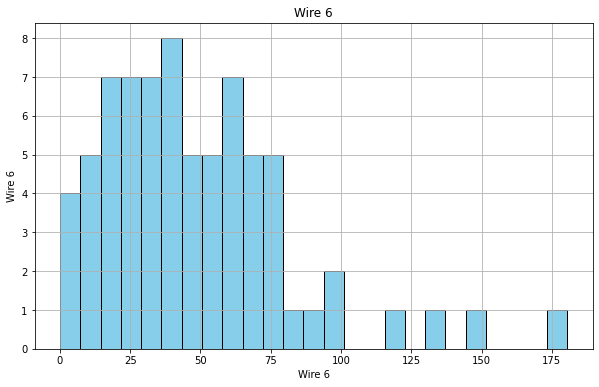

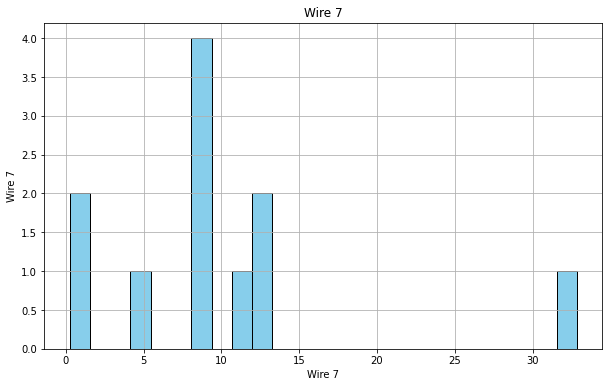

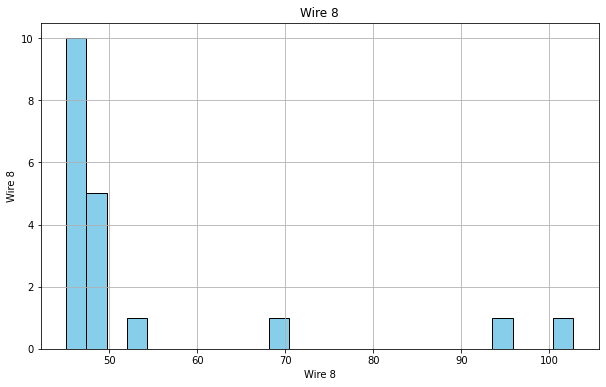

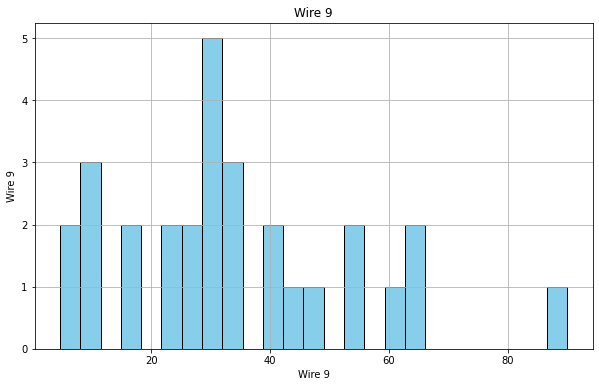

In [80]:
for col in wire_cols:
    num_variable_visualization(data_wire_new, col, title=col)

In [81]:
data_wire_new = data_wire_new.fillna(0)

Добавим новый признак, который содержит суммарный объем материала.

In [82]:
data_wire_new['Суммарный объем проволочных материалов'] = data_wire_new[wire_cols].sum(axis=1)

count    3081.000000
mean      123.723326
std        66.082966
min         1.918800
25%        86.112000
50%       114.179523
75%       150.181198
max       663.851766
Name: Суммарный объем проволочных материалов, dtype: float64


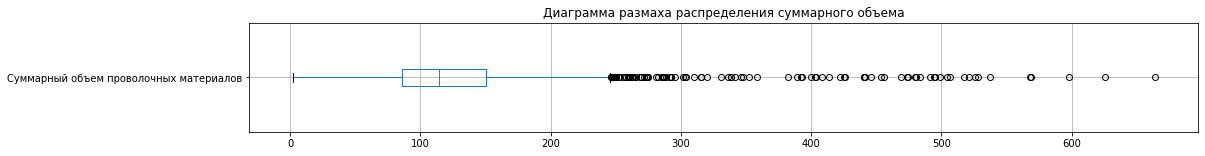

In [83]:
num_variable_analysis(data_wire_new, 'Суммарный объем проволочных материалов', 'распределения суммарного объема')

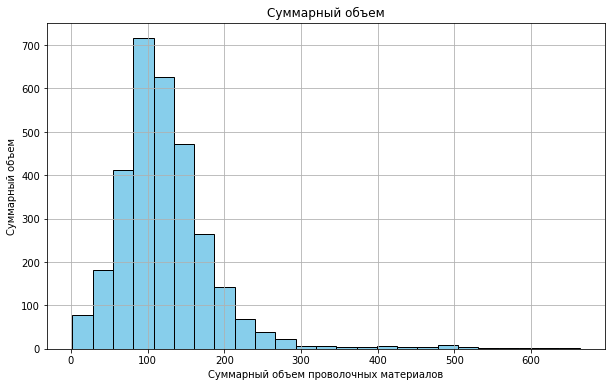

In [84]:
num_variable_visualization(data_wire_new, 'Суммарный объем проволочных материалов', 'Суммарный объем')

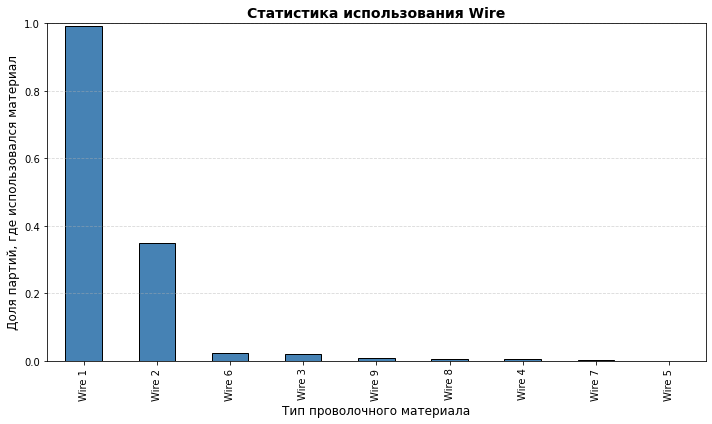

In [85]:
usage_rate = (data_wire_new[wire_cols] > 0).mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = usage_rate.plot(
    kind='bar',
    color='steelblue',
    edgecolor='black'
)

ax.set_title('Статистика использования Wire', fontsize=14, fontweight='bold')
ax.set_ylabel('Доля партий, где использовался материал', fontsize=12)
ax.set_xlabel('Тип проволочного материала', fontsize=12)
ax.set_ylim(0, 1)        
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Удалим те материалы, которые практически не используются.

In [86]:
del_col=['Wire 6', 'Wire 3', 'Wire 9', 'Wire 8', 'Wire 4', 'Wire 7', 'Wire 5']
data_wire_new.drop(columns=del_col, inplace=True)
data_wire_time_new.drop(columns=del_col, inplace=True)

In [87]:
data_wire_new

,key,Wire 1,Wire 2,Суммарный объем проволочных материалов
0,1,60.059998,0.00000,60.059998
1,2,96.052315,0.00000,96.052315
2,3,91.160157,0.00000,91.160157
3,4,89.063515,0.00000,89.063515
4,5,89.238236,9.11456,98.352796
...,...,...,...,...
3076,3237,38.088959,0.00000,38.088959
3077,3238,56.128799,0.00000,56.128799
3078,3239,143.357761,0.00000,143.357761
3079,3240,34.070400,0.00000,34.070400


### Вывод по исследовательскому анализу и предобработки данных

Все датафреймы были проализрованы. Для датафрейма с даннами об электродах было установлено, что основная масса значений сосредоточена в нижнем диапазоне (около 0.3–0.6 у активной мощности, 0.3–0.5 у реактивной), обе гистограммы имеют смещение вправо. В большинстве нагревов значения мощности невысоки, но время от времени встречаются отдельные случаи с большими мощностями. Аномальных значений по времени обнаружено не было,однако в июле 2019 была работа была остановлена на несколько дней.

Для датафрема с данными о подаче сыпучих материалов были удалины Bulk 1, Bulk 11, Bulk 10, Bulk 5, Bulk 7, Bulk 2, Bulk 9, Bulk 13, Bulk 8, так как они очень редко используются. В датафрейме с данными о продувки сплава газом также были обнаружены аномальные значения, но они не были удалены, так как не являются супер выбросами, они возможны. 

В датафрейме с результатами измерения температуры были удалены партии с супер выбросами, значение температур в основном сосредоточено от 1580 до 1650. Для начальной температуры распределение практически симметричное, близкое к нормальному. Есть единичные выбросы ниже 1520 °C и выше 1650 °C, но они крайне редки. Для конечной температуры распределение тоже примерно нормальное, но чуть более «узкое» вокруг центра — большая часть значений лежит в интервале 1580 – 1620 °C. Выбросы в обе стороны есть, но их доля невелика.

Из датафрема с данными о проволочных материалов были удалины те материалы, которые практически не используются.


Также было добавлено несколько новых прихзнаков:
- Полная мощность;
- Коэффициент мощности;
- Время нагрева;
- Суммарный объем;
- Начальная температура;
- Конечная температура;
- Суммарный объем проволочных материалов


## Шаг 3. Объединение данных

In [88]:
tables = [
    data_arc,
    data_bulk_new,
    data_gas_new,
    data_temp_new,
    data_wire_new,    
    data_temp            
]

df_arc  = data_arc.rename(columns={
    'Активная мощность':   'active_power',
    'Реактивная мощность': 'reactive_power',
    'Полная мощность':     'S_apparent',
    'Время нагрева':       'heating_time',
    'Коэффициент мощности':'power_factor'
})

df_bulk = data_bulk_new.rename(columns={'Суммарный объем':'Bulk_total_vol'})
df_gas  = data_gas_new.rename(columns={'Газ 1':'gas_volume'})
df_wire = data_wire_new.rename(columns={'Суммарный объем проволочных материалов':'wire_total_vol'})
df_data_temp = data_temp.rename(columns={ 
    'Начальная температура':  'starting_temperature',
    'Конечная температура': 'final_temperature',  
})

In [89]:
agg_arc = (
    df_arc
    .groupby('key', as_index=False)
    .agg(
       active_power_mean=('active_power','mean'),
       reactive_power_mean=('reactive_power','mean'),
       S_apparent_mean=('S_apparent','mean'),
       heating_time_sum=('heating_time','sum'),
       power_factor_mean=('power_factor', 'mean')
    )
)

In [90]:
tables = [df_data_temp, agg_arc, df_bulk, df_gas, df_wire]

df_final = reduce(
    lambda left, right: pd.merge(left, right, on='key', how='inner'),
    tables
)

print("Rows×Cols:", df_final.shape)
print("Пропусков final_temperature:", df_final['final_temperature'].isna().sum())
print(df_final.isna().sum().sort_values(ascending=False))
print("Columns:", df_final.columns.tolist())

Rows×Cols: (2324, 19)
Пропусков final_temperature: 0
key                     0
Bulk 6                  0
Wire 2                  0
Wire 1                  0
gas_volume              0
Bulk_total_vol          0
Bulk 15                 0
Bulk 14                 0
Bulk 12                 0
Bulk 4                  0
starting_temperature    0
Bulk 3                  0
power_factor_mean       0
heating_time_sum        0
S_apparent_mean         0
reactive_power_mean     0
active_power_mean       0
final_temperature       0
wire_total_vol          0
dtype: int64
Columns: ['key', 'starting_temperature', 'final_temperature', 'active_power_mean', 'reactive_power_mean', 'S_apparent_mean', 'heating_time_sum', 'power_factor_mean', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'Bulk_total_vol', 'gas_volume', 'Wire 1', 'Wire 2', 'wire_total_vol']


In [91]:
df_final.head()

,key,starting_temperature,final_temperature,active_power_mean,reactive_power_mean,S_apparent_mean,heating_time_sum,power_factor_mean,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Bulk_total_vol,gas_volume,Wire 1,Wire 2,wire_total_vol
0,1,1571.0,1613.0,0.607346,0.428564,0.743747,1098.0,0.816686,0.0,43.0,0.0,206.0,150.0,154.0,553.0,29.749986,60.059998,0.00000,60.059998
1,2,1581.0,1602.0,0.534852,0.363339,0.647087,811.0,0.825276,0.0,73.0,0.0,206.0,149.0,154.0,582.0,12.555561,96.052315,0.00000,96.052315
2,3,1596.0,1599.0,0.812728,0.587491,1.003845,655.0,0.809724,0.0,34.0,0.0,205.0,152.0,153.0,544.0,28.554793,91.160157,0.00000,91.160157
3,4,1601.0,1625.0,0.676622,0.514248,0.850010,741.0,0.793923,0.0,81.0,0.0,207.0,153.0,154.0,595.0,18.841219,89.063515,0.00000,89.063515
4,5,1576.0,1602.0,0.563238,0.421998,0.704245,869.0,0.796818,0.0,78.0,0.0,203.0,151.0,152.0,584.0,5.413692,89.238236,9.11456,98.352796


На данном шаге работы были собраны все однострочные таблицы по key. В data_arc агрегировали по партиям средние и суммарные параметры дугового нагрева (active_power_mean, heating_time_sum и т. п.). Собрали единый DataFrame. В нём ровно 3211 строк — по одной на каждую партию, где есть измерения температуры.

In [92]:
df_final

,key,starting_temperature,final_temperature,active_power_mean,reactive_power_mean,S_apparent_mean,heating_time_sum,power_factor_mean,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Bulk_total_vol,gas_volume,Wire 1,Wire 2,wire_total_vol
0,1,1571.0,1613.0,0.607346,0.428564,0.743747,1098.0,0.816686,0.0,43.0,0.0,206.0,150.0,154.0,553.0,29.749986,60.059998,0.00000,60.059998
1,2,1581.0,1602.0,0.534852,0.363339,0.647087,811.0,0.825276,0.0,73.0,0.0,206.0,149.0,154.0,582.0,12.555561,96.052315,0.00000,96.052315
2,3,1596.0,1599.0,0.812728,0.587491,1.003845,655.0,0.809724,0.0,34.0,0.0,205.0,152.0,153.0,544.0,28.554793,91.160157,0.00000,91.160157
3,4,1601.0,1625.0,0.676622,0.514248,0.850010,741.0,0.793923,0.0,81.0,0.0,207.0,153.0,154.0,595.0,18.841219,89.063515,0.00000,89.063515
4,5,1576.0,1602.0,0.563238,0.421998,0.704245,869.0,0.796818,0.0,78.0,0.0,203.0,151.0,152.0,584.0,5.413692,89.238236,9.11456,98.352796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2495,1570.0,1591.0,0.792033,0.552734,0.967180,723.0,0.812727,21.0,0.0,0.0,256.0,129.0,223.0,719.0,7.125735,89.150879,0.00000,89.150879
2320,2496,1554.0,1591.0,0.695820,0.478672,0.845053,940.0,0.819606,0.0,63.0,0.0,256.0,129.0,226.0,796.0,9.412616,114.179527,0.00000,114.179527
2321,2497,1571.0,1589.0,1.201746,0.817364,1.453639,569.0,0.827613,0.0,85.0,0.0,230.0,124.0,226.0,665.0,6.271699,94.086723,9.04800,103.134723
2322,2498,1591.0,1594.0,0.640462,0.447964,0.781983,750.0,0.819245,90.0,0.0,0.0,206.0,129.0,207.0,733.0,14.953657,118.110717,0.00000,118.110717


In [93]:
#data_temp.query('key == 3000')
data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
data_temp_new.query('key == 3000')

,key,Время замера,Температура
16804,3000,2019-08-29 09:48:33,1609.0
16805,3000,2019-08-29 09:53:47,NaN
16806,3000,2019-08-29 10:00:59,NaN
16807,3000,2019-08-29 10:06:16,NaN


## Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма

### Исследовательский анализ

In [94]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
key,2324.0,1251.140275,715.027927,1.000000,628.750000,1254.500000,1867.250000,2499.000000
starting_temperature,2324.0,1587.368761,23.627590,1519.000000,1571.000000,1587.000000,1603.000000,1660.000000
final_temperature,2324.0,1593.372633,11.207457,1541.000000,1587.000000,1593.000000,1598.000000,1653.000000
active_power_mean,2324.0,0.664209,0.128419,0.267676,0.576159,0.655834,0.741883,1.243889
reactive_power_mean,2324.0,0.488921,0.098024,0.196228,0.420039,0.484669,0.546693,0.960763
S_apparent_mean,2324.0,0.825641,0.160411,0.331897,0.714277,0.818302,0.921313,1.572238
heating_time_sum,2324.0,808.196644,340.813828,57.000000,581.000000,778.000000,993.000000,4189.000000
power_factor_mean,2324.0,0.805477,0.013955,0.739789,0.796794,0.806013,0.814802,0.857042
Bulk 3,2324.0,47.317126,75.238050,0.000000,0.000000,0.000000,80.000000,454.000000
Bulk 4,2324.0,37.347676,58.677890,0.000000,0.000000,0.000000,77.250000,281.000000


count    2324.000000
mean     1587.368761
std        23.627590
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: starting_temperature, dtype: float64


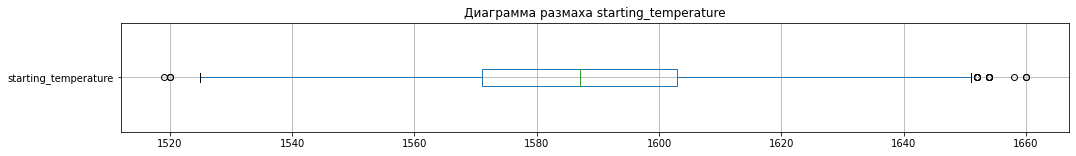

count    2324.000000
mean     1593.372633
std        11.207457
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: final_temperature, dtype: float64


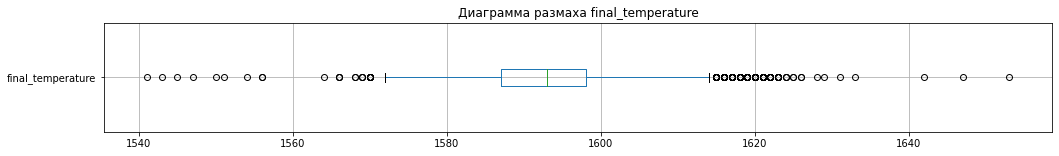

count    2324.000000
mean        0.664209
std         0.128419
min         0.267676
25%         0.576159
50%         0.655834
75%         0.741883
max         1.243889
Name: active_power_mean, dtype: float64


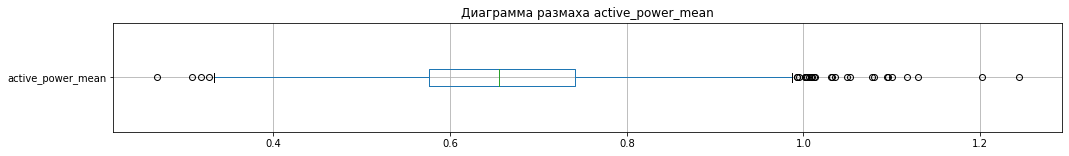

count    2324.000000
mean        0.488921
std         0.098024
min         0.196228
25%         0.420039
50%         0.484669
75%         0.546693
max         0.960763
Name: reactive_power_mean, dtype: float64


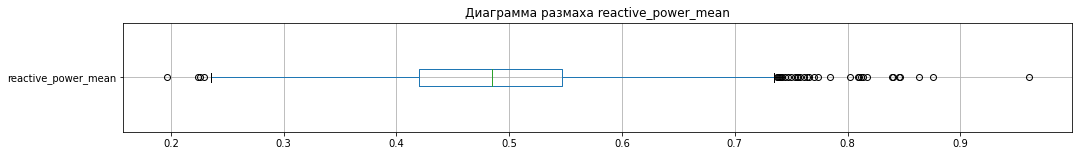

count    2324.000000
mean        0.825641
std         0.160411
min         0.331897
25%         0.714277
50%         0.818302
75%         0.921313
max         1.572238
Name: S_apparent_mean, dtype: float64


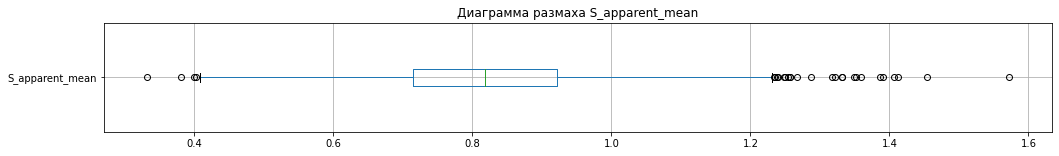

count    2324.000000
mean      808.196644
std       340.813828
min        57.000000
25%       581.000000
50%       778.000000
75%       993.000000
max      4189.000000
Name: heating_time_sum, dtype: float64


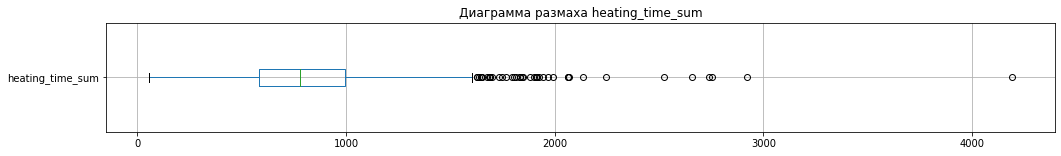

count    2324.000000
mean        0.805477
std         0.013955
min         0.739789
25%         0.796794
50%         0.806013
75%         0.814802
max         0.857042
Name: power_factor_mean, dtype: float64


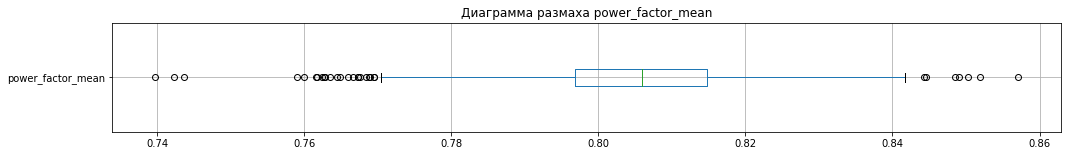

count    2324.000000
mean       47.317126
std        75.238050
min         0.000000
25%         0.000000
50%         0.000000
75%        80.000000
max       454.000000
Name: Bulk 3, dtype: float64


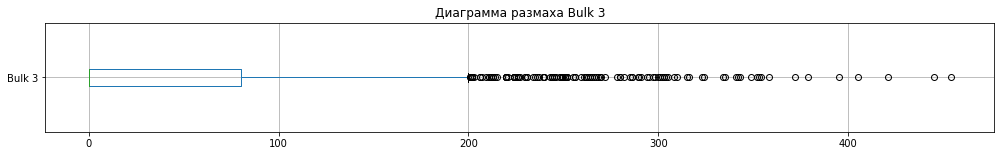

count    2324.000000
mean       37.347676
std        58.677890
min         0.000000
25%         0.000000
50%         0.000000
75%        77.250000
max       281.000000
Name: Bulk 4, dtype: float64


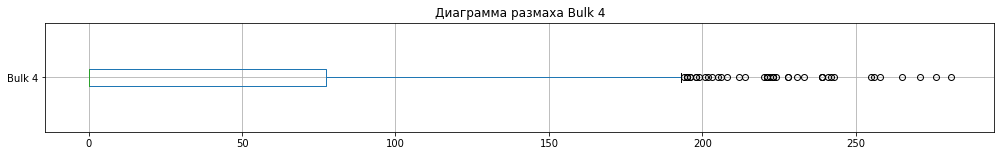

count    2324.000000
mean       22.419535
std        55.792509
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       503.000000
Name: Bulk 6, dtype: float64


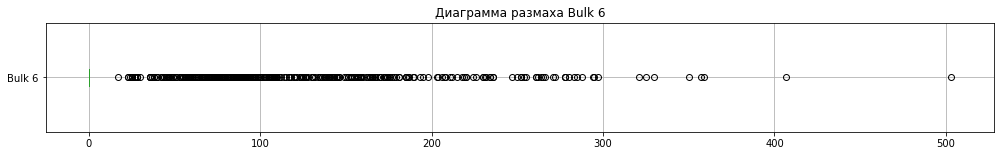

count    2324.000000
mean      208.597676
std       157.112117
min         0.000000
25%       105.000000
50%       206.000000
75%       283.000000
max      1849.000000
Name: Bulk 12, dtype: float64


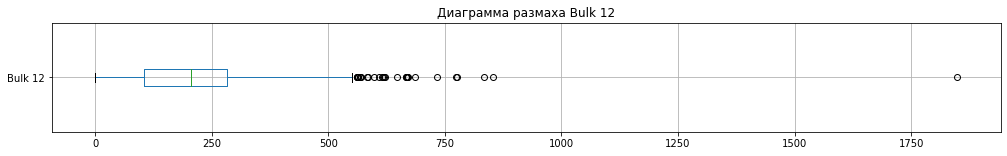

count    2324.000000
mean      153.952668
std        81.410544
min         0.000000
25%       105.000000
50%       149.000000
75%       204.000000
max       636.000000
Name: Bulk 14, dtype: float64


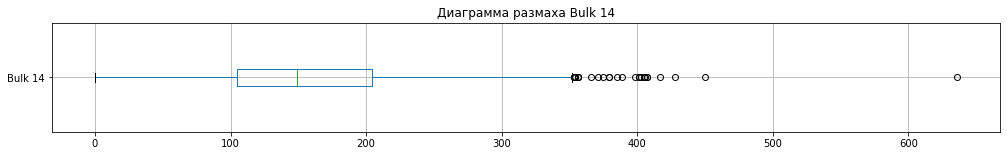

count    2324.000000
mean      120.078313
std        84.655967
min         0.000000
25%         0.000000
50%       107.000000
75%       204.000000
max       405.000000
Name: Bulk 15, dtype: float64


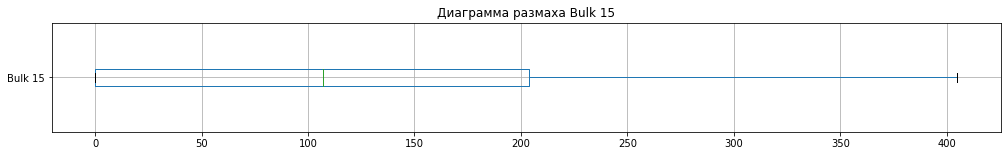

count    2324.000000
mean      610.083046
std       287.574952
min        19.000000
25%       440.000000
50%       609.000000
75%       796.000000
max      3235.000000
Name: Bulk_total_vol, dtype: float64


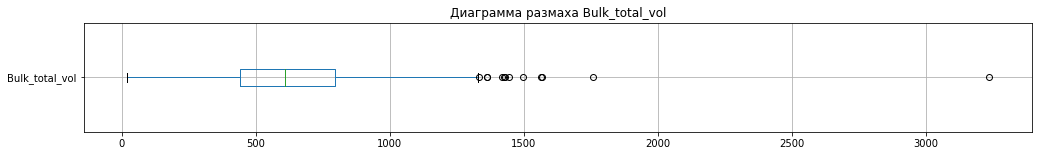

count    2324.000000
mean       11.378854
std         6.397008
min         0.008399
25%         7.282534
50%        10.100687
75%        14.218487
max        77.995040
Name: gas_volume, dtype: float64


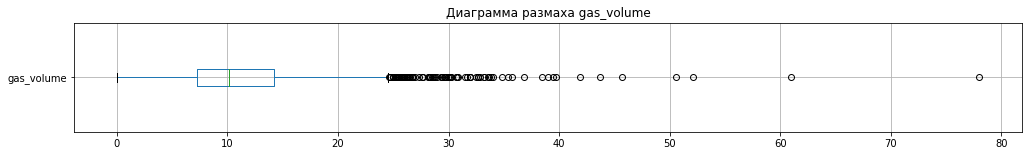

count    2324.000000
mean      102.423900
std        43.540975
min         0.000000
25%        73.204559
50%       101.103600
75%       128.075222
max       330.314424
Name: Wire 1, dtype: float64


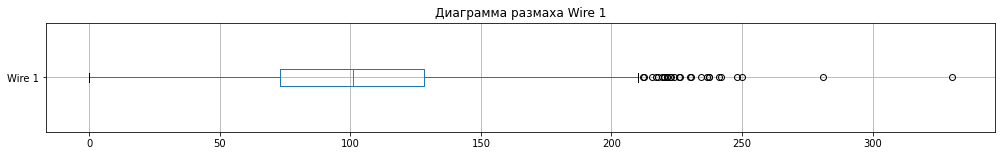

count    2324.000000
mean       17.613213
std        33.648176
min         0.000000
25%         0.000000
50%         0.000000
75%        23.102560
max       282.780152
Name: Wire 2, dtype: float64


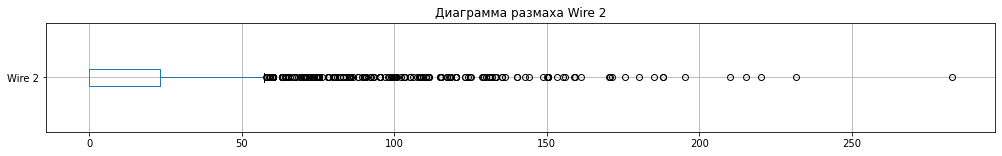

count    2324.000000
mean      125.203274
std        63.690752
min         1.918800
25%        89.048700
50%       116.106121
75%       151.555294
max       568.777664
Name: wire_total_vol, dtype: float64


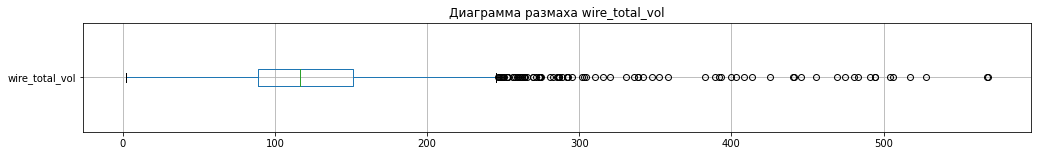

In [95]:
for col in df_final.columns:
    if col == 'key':
        continue
    num_variable_analysis(df_final, col, title=col)

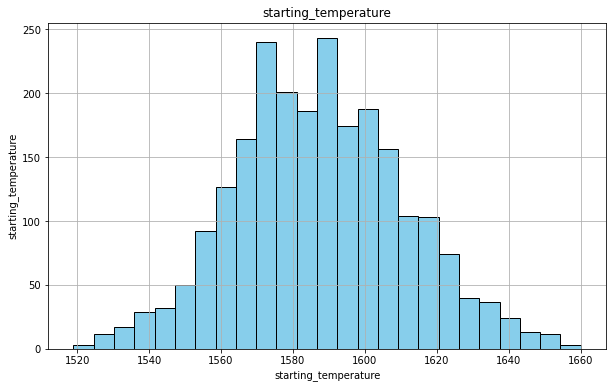

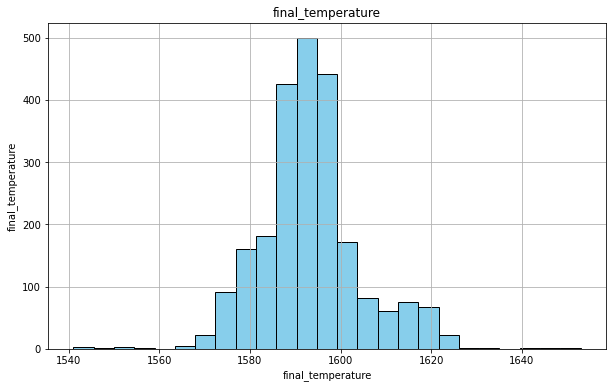

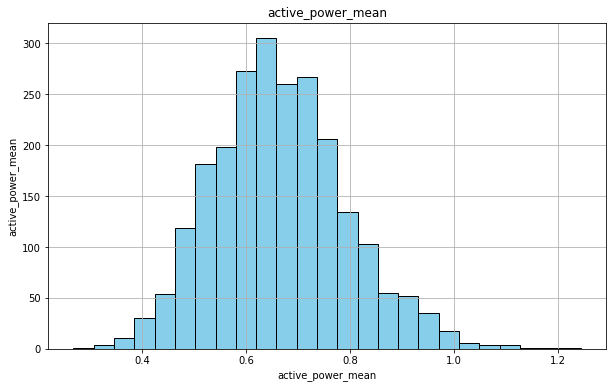

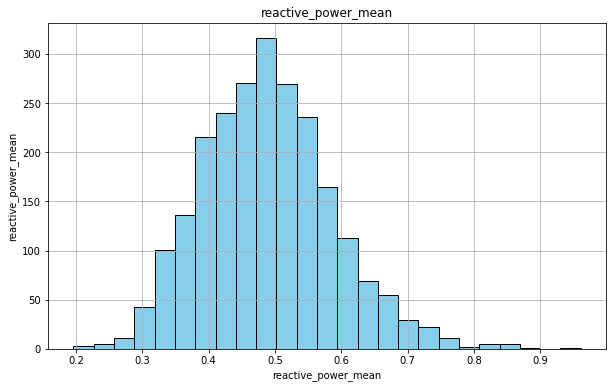

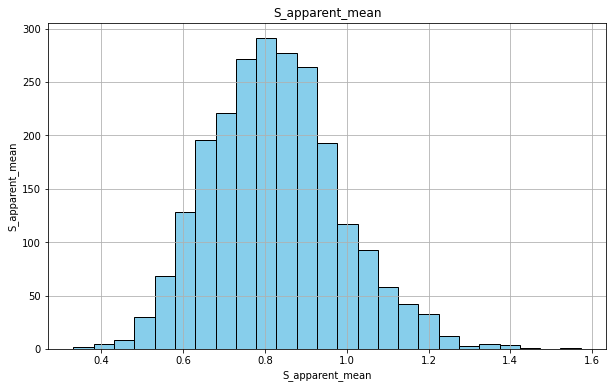

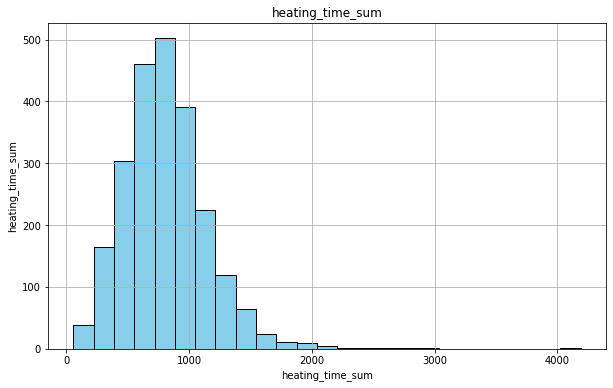

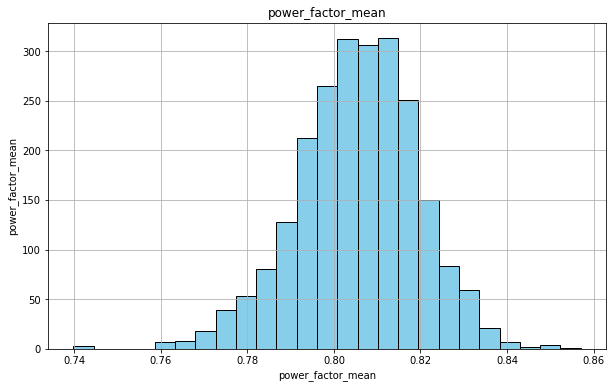

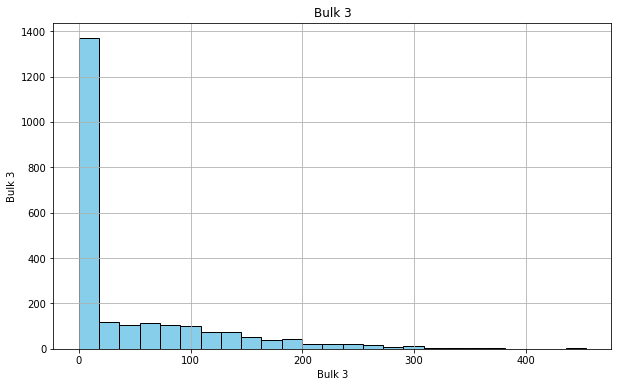

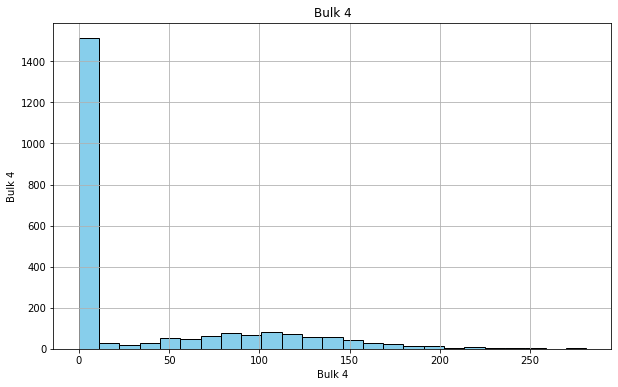

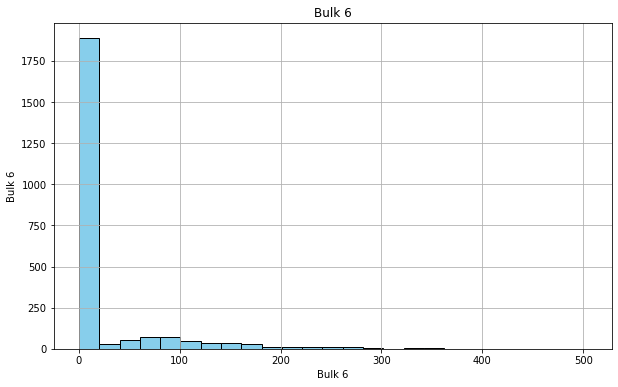

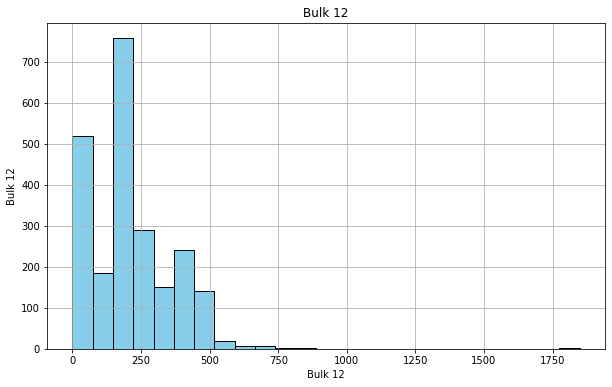

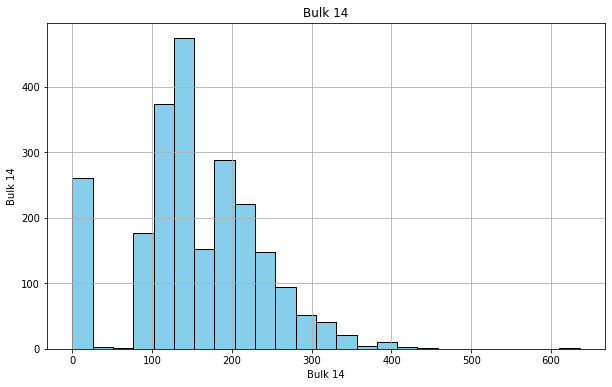

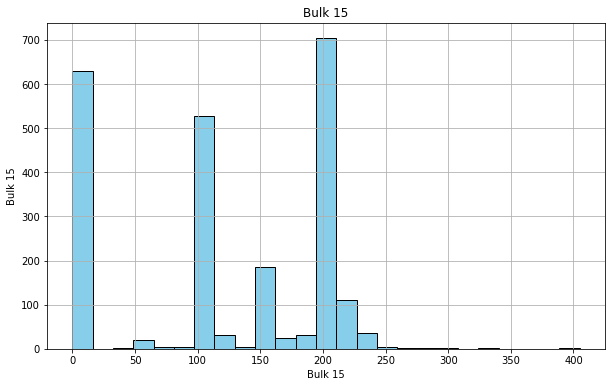

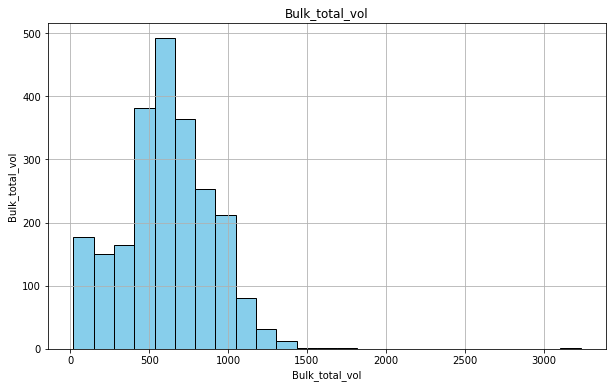

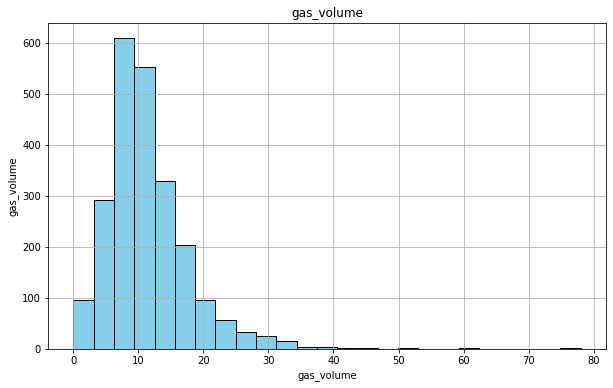

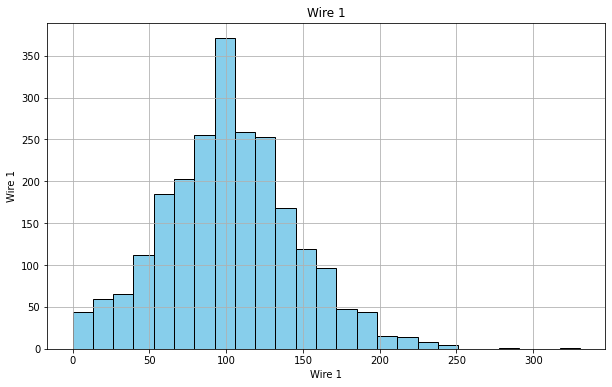

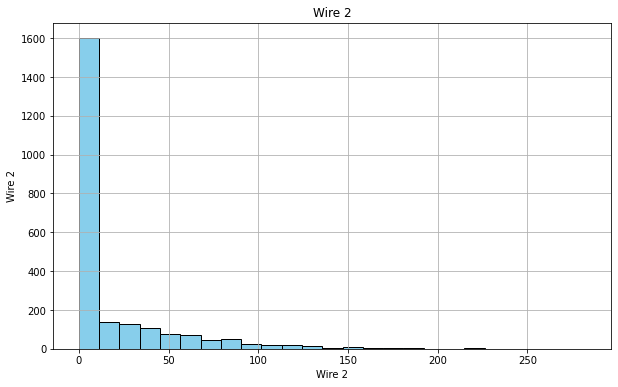

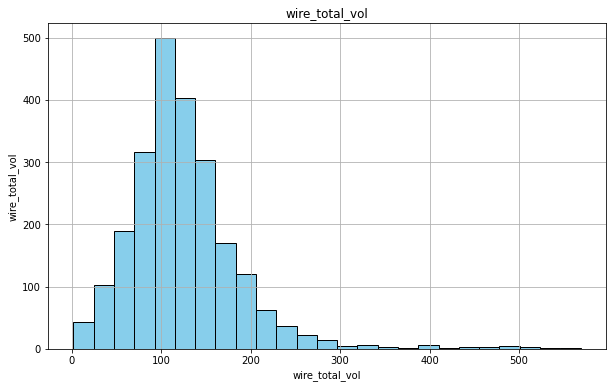

In [96]:
for col in df_final.columns:
    if col == 'key':
        continue
    num_variable_visualization(df_final, col, title=col)

Мощностные признаки (active_power_mean, reactive_power_mean, S_apparent_mean, power_factor_mean) имеют относительно узкий разброс. Время нагрева и объёмы материалов (bulk_*, wire_*, gas_volume) демонстрируют сильную правостороннюю скошенность и длинные «хвосты», а также много нулевых значений (индикатор отсутствия подачи). Температуры (start/end) лежат в узком диапазоне без ярко выраженных выбросов.

### Корреляционный анализ

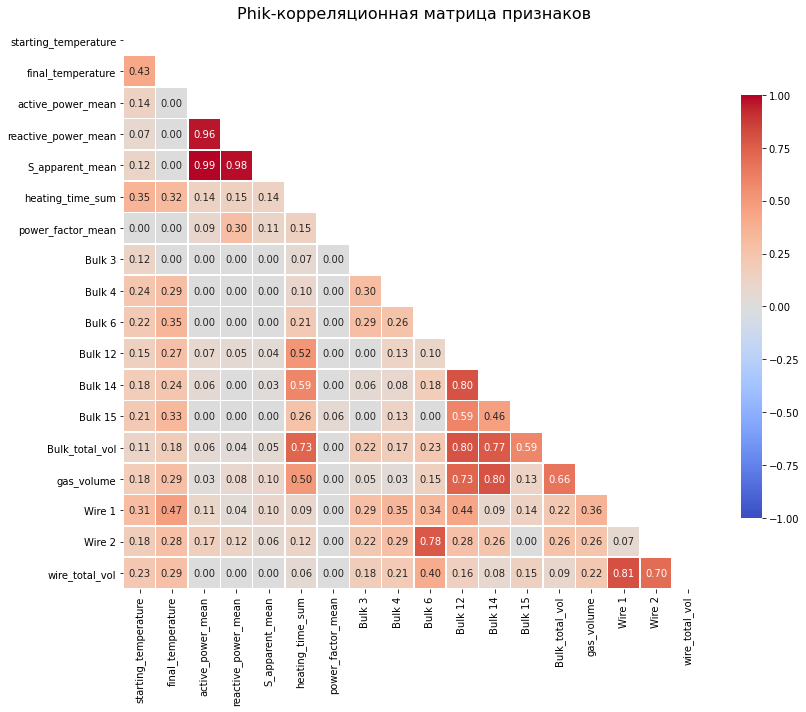

In [97]:
corr_cols = [c for c in df_final.columns if c != 'key']

phik_matrix = df_final[corr_cols].phik_matrix(interval_cols=corr_cols)
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    phik_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    annot_kws={"size": 10}
)
plt.title("Phik‑корреляционная матрица признаков", fontsize=16)
plt.tight_layout()
plt.show()

Можно увидеть мультколлениарность признаков: 

- reactive_power_mean vs S_apparent_mean (Phik ≈ 0.99)
- reactive_power_mean vs active_power_mean и S_apparent_mean (Phik ≈ 0.96–0.98)

С целевой наибольшую корреляцию имеет признак starting_temperature (0.71).

Признак power_facrot_mean имеет коэффициент корреляции 0 с целевым, его стоит удалить.Также стоит удалить S_apparent_mean и reactive_power_mean.


In [98]:
cols_to_drop = [
    'reactive_power_mean',
    'S_apparent_mean',
    'power_factor_mean'
]

df_final = df_final.drop(columns=cols_to_drop)

print("Оставшиеся столбцы:", df_final.columns.tolist())

Оставшиеся столбцы: ['key', 'starting_temperature', 'final_temperature', 'active_power_mean', 'heating_time_sum', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'Bulk_total_vol', 'gas_volume', 'Wire 1', 'Wire 2', 'wire_total_vol']


В данном разделе было установлено, что мощностные признаки (active_power_mean, reactive_power_mean, S_apparent_mean, power_factor_mean) имеют относительно узкий разброс. Время нагрева и объёмы материалов (bulk_, wire_, gas_volume) демонстрируют сильную правостороннюю скошенность и длинные «хвосты», а также много нулевых значений (индикатор отсутствия подачи). Температуры (start/end) лежат в узком диапазоне без ярко выраженных выбросов.

Также был проведен корреляционный анализ, были удалены признаки вызывающие мультиколлениарность, признак, который никак несвязан с целевым.

## Шаг 5. Подготовка данных

In [99]:
df_final

,key,starting_temperature,final_temperature,active_power_mean,heating_time_sum,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Bulk_total_vol,gas_volume,Wire 1,Wire 2,wire_total_vol
0,1,1571.0,1613.0,0.607346,1098.0,0.0,43.0,0.0,206.0,150.0,154.0,553.0,29.749986,60.059998,0.00000,60.059998
1,2,1581.0,1602.0,0.534852,811.0,0.0,73.0,0.0,206.0,149.0,154.0,582.0,12.555561,96.052315,0.00000,96.052315
2,3,1596.0,1599.0,0.812728,655.0,0.0,34.0,0.0,205.0,152.0,153.0,544.0,28.554793,91.160157,0.00000,91.160157
3,4,1601.0,1625.0,0.676622,741.0,0.0,81.0,0.0,207.0,153.0,154.0,595.0,18.841219,89.063515,0.00000,89.063515
4,5,1576.0,1602.0,0.563238,869.0,0.0,78.0,0.0,203.0,151.0,152.0,584.0,5.413692,89.238236,9.11456,98.352796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2495,1570.0,1591.0,0.792033,723.0,21.0,0.0,0.0,256.0,129.0,223.0,719.0,7.125735,89.150879,0.00000,89.150879
2320,2496,1554.0,1591.0,0.695820,940.0,0.0,63.0,0.0,256.0,129.0,226.0,796.0,9.412616,114.179527,0.00000,114.179527
2321,2497,1571.0,1589.0,1.201746,569.0,0.0,85.0,0.0,230.0,124.0,226.0,665.0,6.271699,94.086723,9.04800,103.134723
2322,2498,1591.0,1594.0,0.640462,750.0,90.0,0.0,0.0,206.0,129.0,207.0,733.0,14.953657,118.110717,0.00000,118.110717


In [100]:
X = df_final.drop(['key', 'final_temperature'], axis=1)
y = df_final['final_temperature']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,        
    random_state=RANDOM_STATE,
    shuffle=True
)

In [102]:
numeric_features = X_train.columns.tolist()

numeric_transformer = Pipeline([
    ('scale', StandardScaler())
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
])

In [103]:
models = {
    'Ridge': Pipeline([
        ('pre', preprocessor),
        ('model', Ridge())
    ]),
    'RandomForest': Pipeline([
        ('pre', preprocessor),
        ('model', RandomForestRegressor(random_state=RANDOM_STATE))
    ]),
    'CatBoost': Pipeline([
        ('pre', preprocessor),
        ('model', CatBoostRegressor(
            loss_function='MAE',
            early_stopping_rounds=100,
            random_state=RANDOM_STATE,
            verbose=False
        ))
    ]),
    'LightGBM': Pipeline([
        ('pre', preprocessor),
        ('model', LGBMRegressor(random_state=RANDOM_STATE))
    ]),
}

## Шаг 6. Обучение моделей машинного обучения

In [104]:
param_grids = {
    'Ridge': {
        'model__alpha': [0.1, 1, 10, 100]
    },
    'RandomForest': {
        'model__n_estimators': [200, 500],
       'model__max_depth':    [10, 20],
        'model__min_samples_leaf': [1, 4],
    },
    'CatBoost': {
        'model__learning_rate': [0.03, 0.05],
        'model__depth':         [6, 8],
        'model__iterations':    [500, 1000]
    },
    'LightGBM': {
        'model__n_estimators': [500, 1000],
        'model__learning_rate': [0.03, 0.05],
    }
}

In [105]:
halving_params = dict(
    factor=2,
    aggressive_elimination=True,
    cv=3,                    
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

In [106]:
best_estimators = {}
for name, pipe in models.items():
    print(f"\n=== Тюнинг {name} ===")
    rs = HalvingRandomSearchCV(
        estimator=pipe,
        param_distributions=param_grids[name],
        **halving_params
    )
    rs.fit(X_train, y_train)
    best_estimators[name] = rs.best_estimator_
    
    cv_mae = -rs.best_score_
    print(f"{name} CV MAE: {cv_mae:.2f}°C — params: {rs.best_params_}")


=== Тюнинг Ridge ===
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 9
min_resources_: 6
max_resources_: 1743
aggressive_elimination: True
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 384
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 768
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 2
n_candidates: 1
n_resources: 1536
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Ridge CV MAE: 6.60°C — params: {'model__alpha': 0.1}

=== Тюнинг RandomForest ===
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 9
min_resources_: 6
max_resources_: 1743
aggressive_elimination: True
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 192
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 384
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 7

## Шаг 7. Выбор лучшей модели

In [107]:
best_name = 'CatBoost'
best_pipe = best_estimators[best_name]

y_pred = best_pipe.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f"Лучшая модель: {best_name}")
print(f"MAE на тестовой выборке: {test_mae:.2f} °C")

Лучшая модель: CatBoost
MAE на тестовой выборке: 6.00 °C


## Шаг 8. Исследование важности признаков

In [108]:
X_test_proc = best_pipe.named_steps['pre'].transform(X_test)
feature_names = X_test.columns.tolist()

In [109]:
model_best = best_pipe.named_steps['model']

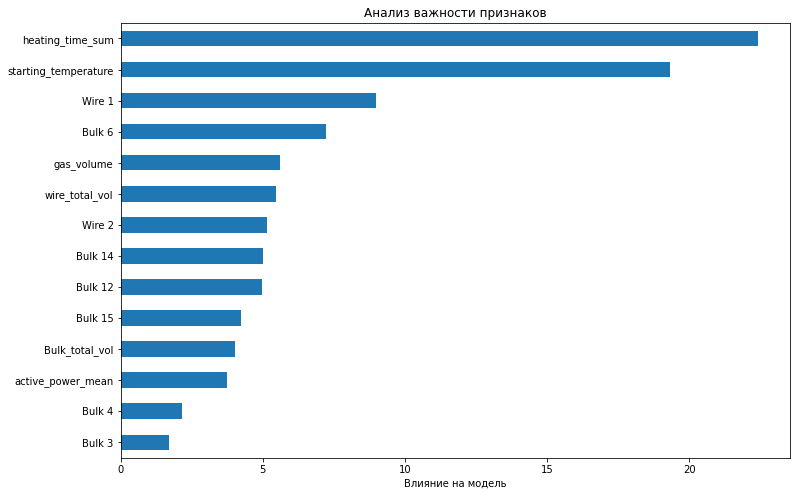

In [110]:
if hasattr(model_best, 'feature_importances_'):
    importances = model_best.feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    fi[:16].plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title('Анализ важности признаков')
    plt.xlabel('Влияние на модель')
    plt.show()

In [111]:
explainer = shap.TreeExplainer(model_best)
shap_values = explainer.shap_values(X_test_proc)

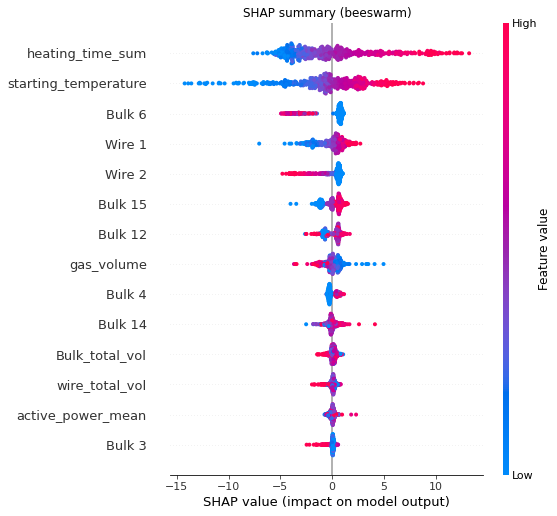

In [112]:
shap.summary_plot(
    shap_values, 
    X_test_proc, 
    feature_names=feature_names,
    max_display=16,
    show=False
)
plt.title('SHAP summary (beeswarm)')
plt.show()

Наиблольшее влияние на целевую переменную оказывают:

- суммарное время нагрева;
- стартавая температура;
- Bulk 6;
- Wire 1;

Стартавая температура и суммарное время нагрева —  доминирующие признаки, они занимают топ-2 позиции на обоих графиках. Высокая важность и  широкий разброс SHAP-значений указывают на их решающее влияние на прогнозы модели.

## Шаг 9. Итоговый вывод

Для оптимизации производственных расходов, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.

Задача — построить модель, которая будет предсказывать температуру сплава.

Заказчик хочет использовать разработанную модель для имитации технологического процесса.

В ходе исследовательского анализа и предобработки данные были проверены на пропуски, изучены и скорректированы типы некоторых переменных. Были удалены супер-выбросы, остальные выбросы возможны, принято решение их оставить. Из датафремов с данными о проволочных и сыпучих материалов были удалины те материалы, которые практически не используются.

Добавлены новые признаки:
- Полная мощность;
- Коэффициент мощности;
- Время нагрева;
- Суммарный объем;
- Начальная температура;
- Конечная температура;
- Суммарный объем проволочных материалов

Необходимые датафреймы были объединены. На данном шаге работы были собраны все однострочные таблицы по key. В data_arc агрегировали по партиям средние и суммарные параметры дугового нагрева (active_power_mean, heating_time_sum и т. п.). Собрали единый DataFrame. Удалены ковши, которые не содержат целевую переменную. 

На этапе анализа объединенного датафрейма было установлено, что мощностные признаки (active_power_mean, reactive_power_mean, S_apparent_mean, power_factor_mean) имеют относительно узкий разброс. Время нагрева и объёмы материалов (bulk_, wire_, gas_volume) демонстрируют сильную правостороннюю скошенность и длинные «хвосты», а также много нулевых значений (индикатор отсутствия подачи). Температуры (start/end) лежат в узком диапазоне без ярко выраженных выбросов. Также был проведен корреляционный анализ, были удалены признаки вызывающие мультиколлениарность, признак, который никак несвязан с целевым.

Итоговые признаки: ['key', 'starting_temperature', 'final_temperature', 'active_power_mean', 'heating_time_sum', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'Bulk_total_vol', 'gas_volume', 'Wire 1', 'Wire 2', 'wire_total_vol'] 

Для обучение были выбраны следующие модели:'Ridge','RandomForest','CatBoost','LightGBM'. Лучше всего себя проявил 'CatBoost'. Результаты на тестовой выборке: 6.00 °C.


Гиперпараметры лучшей модели:  {'iterations': 500, 'learning_rate': 0.03, 'depth': 6, 'loss_function': 'MAE', 'verbose': False, 'random_state': 30625, 'early_stopping_rounds': 100}.